In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Story Telling Notebook

This notebook is concerned with investigating the relationship between GME stock prices and key indicators to several of the topics derived from the LDA topic modeling done on the WallStreetBets posts and comments data that I scraped from the reddit API using PSAW.

Of the 40 topics determined by our model 14 of them were interpretable, meaning a central theme could be determined by looking at the combined words. We are primarily interested in looking at these different time series to detect any possible leader/follower behavior before the Jan '21 short squeeze of GME stocks. 

The 14 topics we shall be looking into are:

    - 1: buying and selling gold
    - 2: Investing in Apple
    - 4: Investing in Netflix
    - 6: Short Squeeze
    - 7: Potential roi investing in a company
    - 8: Push up the price of a stock
    - 14: 2020 election
    - 18: Buy and Hold don't sell
    - 19: oil prices and trading with Robinhood
    - 26: Market trending down
    - 27: Invest based on post trading trends
    - 31: Market reversing from bear to bull
    - 35: Response to price drop
    - 38: Covid

On the part of GME stocks we are going to primarily look at the VWAP, RSI, and stochastic-RSI indicators.

We shall be conducting correlation tests over the training period and validation period to see how trends align across these time frames. Furthermore we shall be looking at several other indicators of relationship such as: Windowed pearson correlation, Dynamic Time Warping, and Time Lagged Cross Correlation.

This project has been considered from the perspective of a large scale financial institution that is seeking to minimize loss in the future. Seeing the organizational power demonstrated by the WSB community, was there any indication of potential acting power in advance of the Jan. '21 event? Can we derive topics from the corpus of posts and comments to determine correlation in price momentum? Here is where we seek to do just that.

In [2]:
keep_topics = [1,2,4,6,7,8,14,18,19,26,27,31,35,38]

In [4]:
#!pip install dtw

In [5]:
import pandas as pd
import numpy as np
import pathlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [6]:
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [7]:
from dtw import dtw,accelerated_dtw

In [ ]:
#!pip install --upgrade statsmodels

In [ ]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

In [9]:
sns.set_style('darkgrid')

In [10]:
cwd = pathlib.Path.cwd()
cst_loc = cwd / 'gdrive/My Drive/Capstone_two'

## Topic Frequencies


In [11]:
df_one = pd.read_pickle(cst_loc/'training_labeled_ts.pkl')

In [12]:
topic_frequencies = df_one.groupby(['dt','primary_topic'])['id'].count().reset_index()

In [13]:
topic_pivot = topic_frequencies.pivot(index='dt', columns=['primary_topic'], values='id')

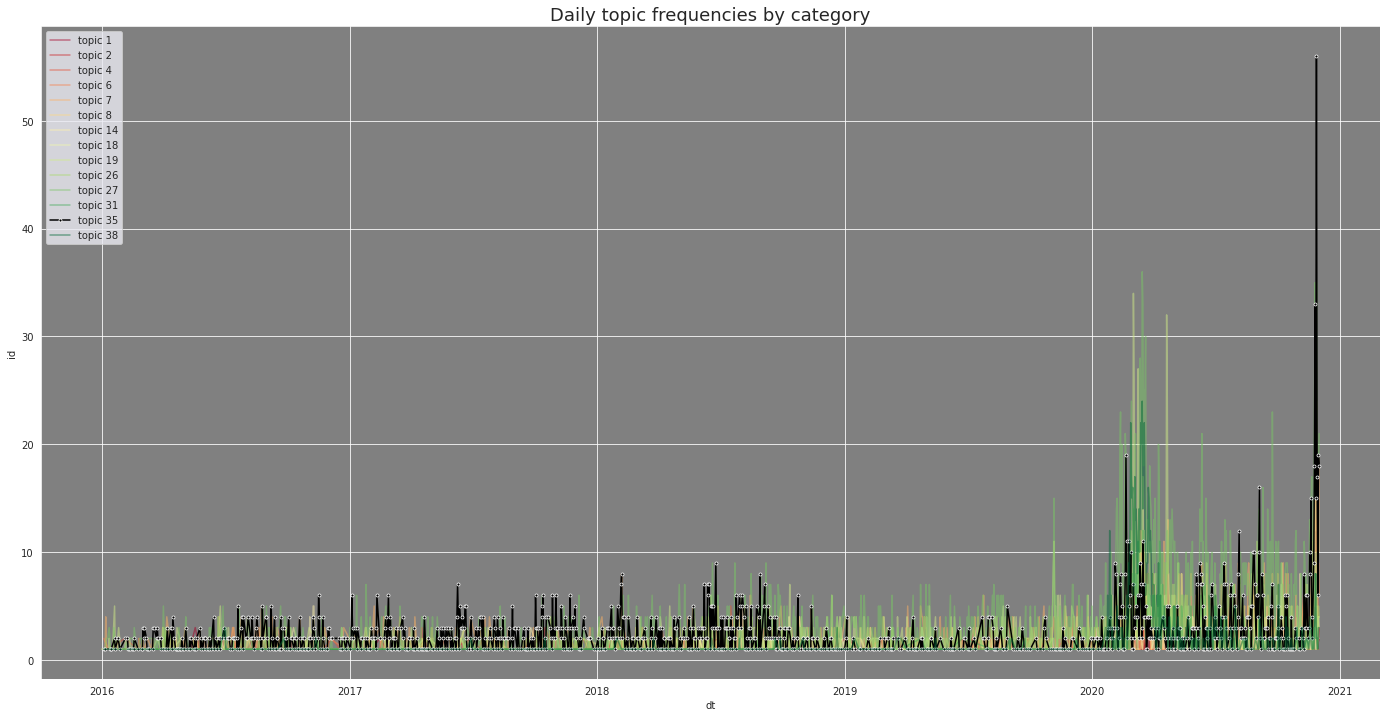

In [17]:
colors = [cm.RdYlGn(i) for i in np.linspace(0,1,len(keep_topics))]

_, ax = plt.subplots(1,1,figsize=(24,12))
ax.set_facecolor('gray')
for i in range(len(keep_topics)):
    data = topic_frequencies[topic_frequencies.primary_topic == keep_topics[i]]
    if keep_topics[i] == 35:
        sns.lineplot(data = data, x='dt', y='id', color='black', marker='.', label=f'topic {keep_topics[i]}')
    else:
        sns.lineplot(data = data, x='dt', y='id', color=colors[i], label=f'topic {keep_topics[i]}', alpha=0.5)

ax.set_title('Daily topic frequencies by category', fontsize=18)

plt.show()

Looking at the per day topic frequencies from 2016-01-01 until 2020-12-01 there appears to be an interesting increase in topic 0 frequencies in the first quater of 2018.

In [20]:
df_two = pd.read_pickle(cst_loc/'validation_labeled_ts.pkl')

In [21]:
val_topics = df_two.groupby(['dt','primary_topic'])['id'].count().reset_index()

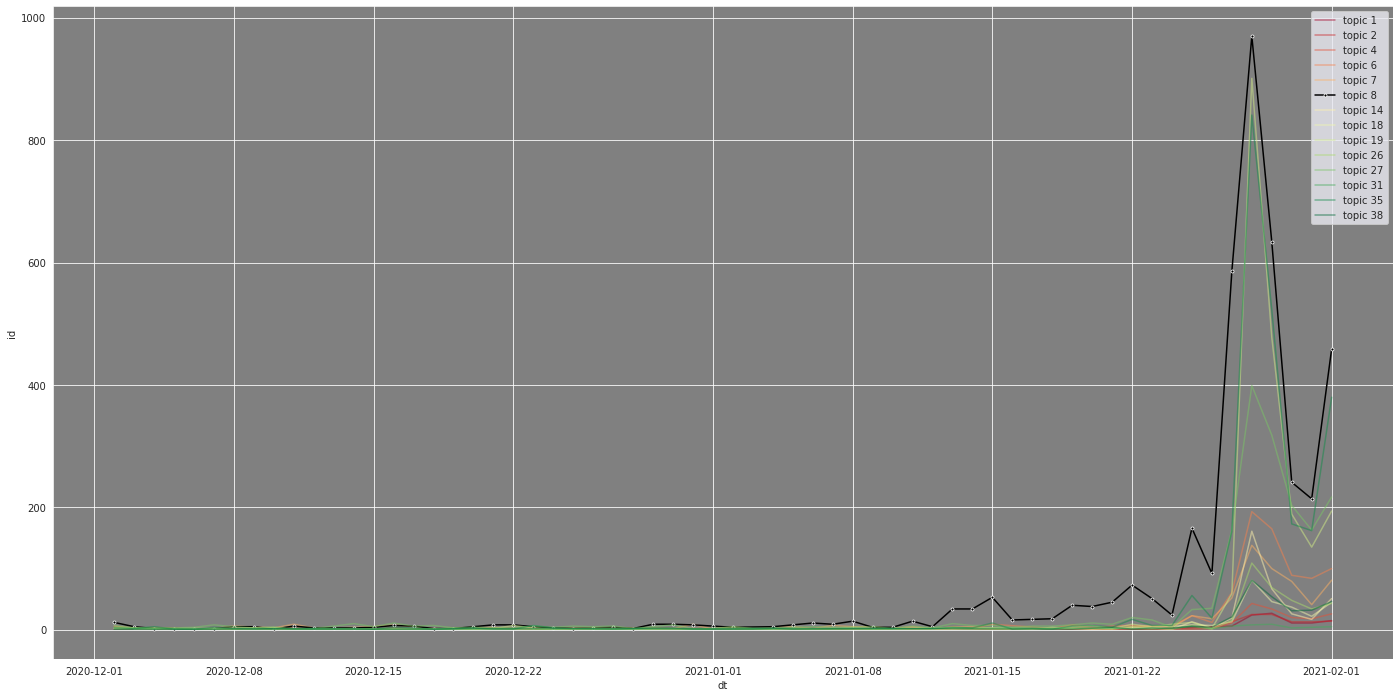

In [23]:
colors = [cm.RdYlGn(i) for i in np.linspace(0,1,len(keep_topics))]

_, ax = plt.subplots(1,1,figsize=(24,12))
ax.set_facecolor('gray')

for i in range(len(keep_topics)):
    data = val_topics[val_topics.primary_topic == keep_topics[i]]
    if keep_topics[i] == 8:
        sns.lineplot(data = data, x='dt', y='id', color='black', marker='.',label=f'topic {keep_topics[i]}')
    else:
        sns.lineplot(data = data, x='dt', y='id', color=colors[i],label=f'topic {keep_topics[i]}', alpha = 0.5)
plt.show()

Isolating to the period in time in which we predicted the topics yields interesting increases in topics 0, 22, and 34. We are able to see however that sometime around mid to late december of 2020 topic 22 becomes the dominant topic until the end of january.

In [24]:
whole = pd.concat([topic_frequencies, val_topics], ignore_index=True).reset_index()

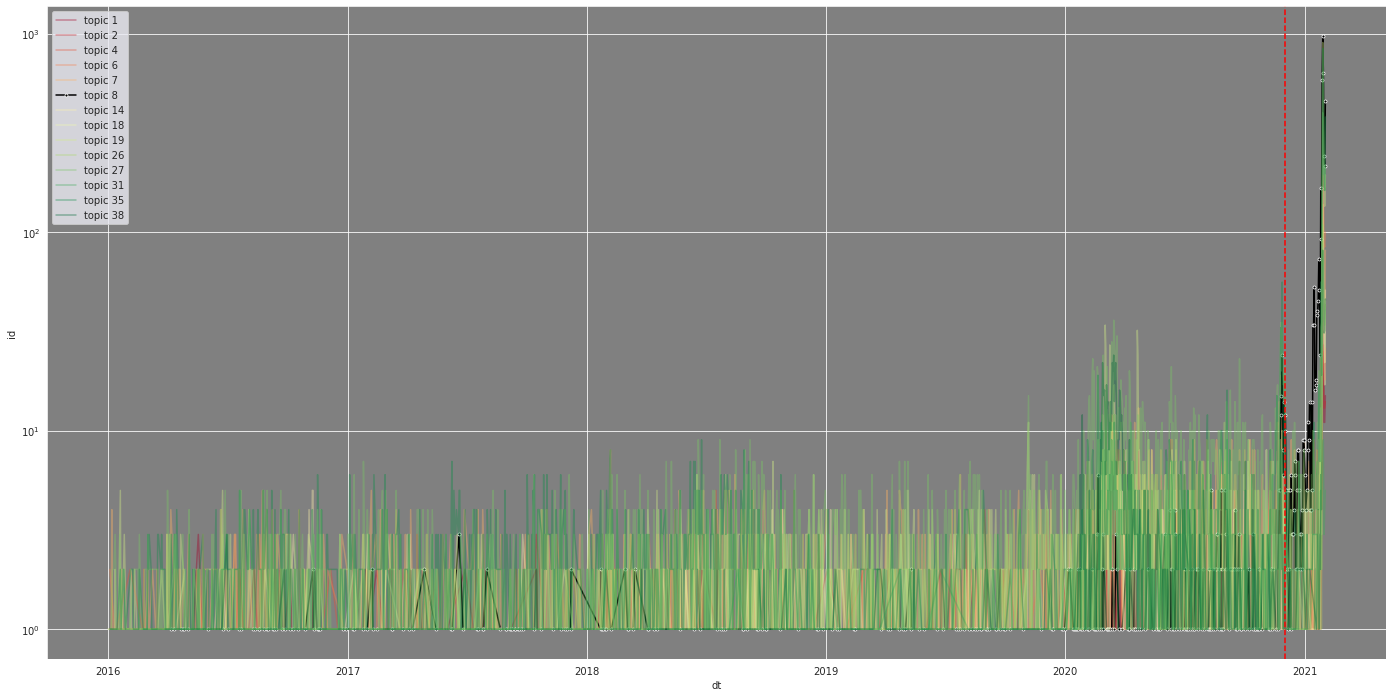

In [27]:
colors = [cm.RdYlGn(i) for i in np.linspace(0,1,len(keep_topics))]

_, ax = plt.subplots(1,1,figsize=(24,12))
ax.set_facecolor('gray')

for i in range(len(keep_topics)):
    data = whole[whole.primary_topic == keep_topics[i]]
    if keep_topics[i] == 8:
        sns.lineplot(data = data, x='dt', y='id', color='black', marker='.',label=f'topic {keep_topics[i]}')
    else:
        sns.lineplot(data = data, x='dt', y='id', color=colors[i],label=f'topic {keep_topics[i]}', alpha=0.4)

ax.axvline(x=pd.to_datetime('2020-12-02'), color='red', linestyle='--')
ax.set_yscale('log')
plt.show()

Setting the y-scale to log helps to better visualize the minute changes in the data over the whole period. We see smaller increases between 2018-2019 as well as a sharp yet sustained increase in frequencies throughout 2020 building up to the massive spike in topics at the beginning of 2021.

In [28]:
whole_pivoted = whole.pivot(index='dt', columns=['primary_topic'], values='id').fillna(0)
whole_pivoted = whole_pivoted[keep_topics]

In [29]:
df_prices = pd.read_csv(cst_loc/'price_indicators.csv', parse_dates=['Date'])

In [30]:
df_prices = df_prices.set_index('Date')

In [31]:
df_prices.tail()

Date.1  Close/Last  ...  STOCHRSIk_14_14_3_3  STOCHRSId_14_14_3_3
Date                                ...                                          
2021-01-26  2021-01-26      147.98  ...           100.000000            92.138270
2021-01-27  2021-01-27      347.51  ...           100.000000            97.679059
2021-01-28  2021-01-28      193.60  ...            74.685158            91.561719
2021-01-29  2021-01-29      325.00  ...            51.453744            75.379634
2021-02-01  2021-02-01      225.00  ...            18.120410            48.086437

[5 rows x 13 columns]

In [32]:
df_prices['sma_50'] = df_prices['Close/Last'].rolling(50).mean()
df_prices['std_50'] = df_prices['Close/Last'].rolling(50).std(ddof=0)

In [33]:
df_prices['bbandu'] = df_prices['sma_50'] + 2*df_prices['std_50']
df_prices['bbandl'] = df_prices['sma_50'] - 2*df_prices['std_50']

In [34]:

def make_cdlstk(frame,logscale=False):
    fig = make_subplots(rows = 3, cols = 1, shared_xaxes = True, subplot_titles = ('GME', 'Volume', 'RSI'), vertical_spacing = 0.05, row_width = [0.2, 0.2, 0.5])
    #candlestick plot
    fig.add_trace(go.Candlestick(
        x=frame.index,
        open = frame['Open'],
        high = frame['High'],
        low= frame['Low'],
        close = frame['Close/Last'],
        name='gme_candlestick')
    ,row=1, col=1)
    #sma_50
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['sma_50'],
            line_color='goldenrod',
            name='sma_50')
        ,row=1, col=1)
    #bollingerbands
    fig.add_trace(go.Scatter(
            x=frame.index,
            y=frame['bbandu'],
            line_color='goldenrod',
            line={'dash':'dash'},
            name='upper band',
            opacity=0.5),
        row=1, col=1)
    fig.add_trace(go.Scatter(
            x=frame.index,
            y=frame['bbandl'],
            line_color='goldenrod',
            line={'dash':'dash'},
            fill = 'tonexty',
            name='lower band',
            opacity=0.5),
        row=1, col=1)
    #VWAP
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['VWAP'],
            line_color='green',
            name='vwap',
            opacity=0.5)
        ,row=1, col=1)
    # vwmas
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['VWMA_50'],
            line_color='cyan',
            name='vwma_50',
            opacity=0.5)
        ,row=1, col=1)
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['VWMA_100'],
            line_color='purple',
            name='vwma_100',
            opacity=0.5)
        ,row=1, col=1)
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['VWMA_200'],
            line_color='pink',
            name='vwma_200',
            opacity=0.5)
        ,row=1, col=1)
    #volume
    fig.add_trace(go.Bar(
        x = frame.index,
        y = frame['Volume'],
        name='volume',
        opacity=1,
        marker_color='darkred'),
    row=2, col=1)
    #rsi and stochrsi
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['RSI'],
            line_color='green',
            name='rsi')
        ,row=3, col=1)
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['STOCHRSIk_14_14_3_3'],
            line_color='blue',
            name='stchrsi_k',
            opacity=0.5)
        ,row=3, col=1)
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['STOCHRSId_14_14_3_3'],
            line_color='red',
            name='stchrsi_d',
            opacity=0.5)
        ,row=3, col=1)
    fig.add_trace(go.Scatter(
        name='rsi_80',
        x=[frame.index.min(),frame.index.max()],
        y=[80,80],
        line_color='grey',
        line={'dash':'dash'},
        opacity=0.4
        )
    ,row=3,col=1)

    fig.add_trace(go.Scatter(
        name='rsi_20',
        x=[frame.index.min(),frame.index.max()],
        y=[20,20],
        line_color='grey',
        line={'dash':'dash'},
        fill='tonexty',
        opacity=0.4
        )
    ,row=3,col=1)

    fig.add_trace(go.Scatter(
        name='rsi_70',
        x=[frame.index.min(),frame.index.max()],
        y=[70,70],
        line_color='black',
        line={'dash':'dash'},
        opacity=0.4
        )
    ,row=3,col=1)

    fig.add_trace(go.Scatter(
        name='rsi_30',
        x=[frame.index.min(),frame.index.max()],
        y=[30,30],
        line_color='black',
        line={'dash':'dash'},
        fill='tonexty',
        opacity=0.4
        )
    ,row=3,col=1)

    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.update_layout(height=1000, width=1400)
    if logscale:
        fig.update_yaxes(type='log',row=1,col=1)

    fig.show();


In [35]:
make_cdlstk(df_prices, True)

From the above figure we can see that there is a sustained downward trend in gme stock prices lasting until ~ 2020-08. 

From the RSI we can see that there were historic periods where the price of stocks were driven down and held at low values that one could consider to be undervalued. 

In [36]:
merged = pd.merge(whole_pivoted[keep_topics].fillna(0), df_prices[['VWAP','RSI','STOCHRSIk_14_14_3_3','STOCHRSId_14_14_3_3']], left_index=True, right_index=True, how='outer').interpolate('linear').fillna(0)

In [37]:
merged.tail()

1     2  ...  STOCHRSIk_14_14_3_3  STOCHRSId_14_14_3_3
2021-01-28  24.0  25.0  ...            74.685158            91.561719
2021-01-29  27.0  25.0  ...            51.453744            75.379634
2021-01-30  11.0  13.0  ...            40.342633            66.281902
2021-01-31  11.0  13.0  ...            29.231522            57.184170
2021-02-01  15.0  14.0  ...            18.120410            48.086437

[5 rows x 18 columns]

### Pearson Correlation:

We have seen from the above figures that there are different behaviors and patterns over different time periods. It can clearly be see that there is an inverse trend between the selected topics and GME stock prices from 2016 until around 2020-08. That is over this period of time GME stock prices are decreasing with a steady increase in the overall frequency of topics per day on WallStreetBets.

### VWAP
Our first investigation will be against the Volume Weighted Average Price for GME.

In [38]:
for item in merged.columns:
    merged[item] = np.log1p(merged[item])

In [45]:
train_corrs = {item:np.corrcoef(merged.loc[:'2020-12-01'][item], merged.loc[:'2020-12-01']['VWAP'])[0,1] for item in keep_topics}
train_corrs = {key:val for key, val in sorted(train_corrs.items(), key= lambda x: x[1], reverse=True)}
for key, val in train_corrs.items():
    print(f'topic {key} correlation with VWAP: {val}')

topic 35 correlation with VWAP: -0.08836026355748122
topic 1 correlation with VWAP: -0.18117796022969032
topic 2 correlation with VWAP: -0.20201195965458346
topic 4 correlation with VWAP: -0.20836555629269002
topic 8 correlation with VWAP: -0.21863700156443022
topic 18 correlation with VWAP: -0.30888573528880275
topic 14 correlation with VWAP: -0.32468324427363043
topic 26 correlation with VWAP: -0.3764076126218903
topic 6 correlation with VWAP: -0.3842634249524585
topic 7 correlation with VWAP: -0.39029695389036545
topic 38 correlation with VWAP: -0.4303427068545222
topic 19 correlation with VWAP: -0.4462847743900507
topic 31 correlation with VWAP: -0.4730467277560854
topic 27 correlation with VWAP: -0.5003305480473272


Indeed we verify this with pearson correlation. The three dominant topics over this period of time are: topic #27, topic #31, and topic #19. Investing based on after market trends, market reversal, and trading with robinhood respectively.

In [46]:
val_corrs = {item: np.corrcoef(merged.loc['2020-12-02':][item], merged.loc['2020-12-02':]['VWAP'])[0,1] for item in keep_topics}
val_corrs = {key:val for key, val in sorted(val_corrs.items(), key=lambda x: x[1], reverse=True)}
for key, val in val_corrs.items():
    print(f'topic {key} correlation with VWAP: {val}')

topic 8 correlation with VWAP: 0.9216874268164784
topic 27 correlation with VWAP: 0.9024453336093705
topic 35 correlation with VWAP: 0.9016050336988375
topic 6 correlation with VWAP: 0.8968756175797716
topic 4 correlation with VWAP: 0.8819054242711499
topic 18 correlation with VWAP: 0.8778112820530504
topic 14 correlation with VWAP: 0.8716285397659088
topic 19 correlation with VWAP: 0.8532265534839314
topic 38 correlation with VWAP: 0.8461772203550276
topic 26 correlation with VWAP: 0.8002253797095461
topic 7 correlation with VWAP: 0.7997486956399847
topic 2 correlation with VWAP: 0.7742155887234449
topic 1 correlation with VWAP: 0.7575338528277816
topic 31 correlation with VWAP: 0.7181507826398438


Over the validation period the correlation switches from somewhat to weakly negative correlation, to strongly positive across all topics with the top 3 dominant topics of: #8, 27 and 35. Pushing up the price of a stock, post trading trends, and response to dips in price.

In [47]:
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        y_shift = datay.shift(lag)
        y_shift.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(y_shift)
    else:
        return datax.corr(datay.shift(lag))

def wtlcc(frame, col_1, col_2,wrap=False, no_splits =10, abs_bounds = 10):
    datax = frame.reset_index()[col_1]
    datay = frame.reset_index()[col_2]
    no_samples = int(merged.shape[0]/no_splits)
    lower_bound = -int(abs_bounds-1)
    upper_bound = int(abs_bounds)
    rss = []
    for t in range(0,no_splits):
        d1 = datax.loc[(t)*no_samples:(t+1)*no_samples]
        d2 = datay.loc[(t)*no_samples:(t+1)*no_samples]
        rs = [crosscorr(d1,d2, lag=lag) for lag in range(lower_bound, upper_bound)]
        rss.append(rs)
    rss_frame = pd.DataFrame(rss)
    
    _, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(rss_frame, cmap='RdBu_r', ax = ax)
    ax.set(title=f'Windowed time lagged cross correlation between topic: {col_1} and {col_2} with an offset of {upper_bound}',xlim=[0,2*upper_bound -1], xlabel='Offset', ylabel='Window Epoch')
    ax.set_xticklabels([int(item + lower_bound) for item in ax.get_xticks()])
    plt.show()



The above code was adapted into functions from code found here:

Hyun Cheong, J (2021) synchrony_tutorial (Version 2.0) [Source code]. https://gist.github.com/jcheong0428/4a74f801e770c6fdb08e81a906902832


In [89]:
glbl_corrs = {item: crosscorr(merged[item], merged['VWAP']) for item in keep_topics}
glbl_corrs = {key: val for key, val in sorted(glbl_corrs.items(), key=lambda x: abs(x[1]), reverse=True)}
for key, val in glbl_corrs.items():
    print(f'topic {key} correlation with VWAP: {val}')

topic 31 correlation with VWAP: -0.36604433784705065
topic 27 correlation with VWAP: -0.323926430063481
topic 38 correlation with VWAP: -0.2724365256857283
topic 19 correlation with VWAP: -0.25624199090877087
topic 7 correlation with VWAP: -0.2323199719476814
topic 26 correlation with VWAP: -0.22413230374918758
topic 14 correlation with VWAP: -0.17242709158192931
topic 6 correlation with VWAP: -0.16520296589474875
topic 8 correlation with VWAP: 0.13482271340409752
topic 18 correlation with VWAP: -0.10586759643379161
topic 35 correlation with VWAP: 0.061592645556766516
topic 2 correlation with VWAP: -0.043042600487782356
topic 4 correlation with VWAP: -0.038868857018734236
topic 1 correlation with VWAP: -0.03379335514188474


The above values are essentially the global trends across the entire series between all identified topics and the $GME VWAP. The dominant topics globally are 31 27 and 38. 

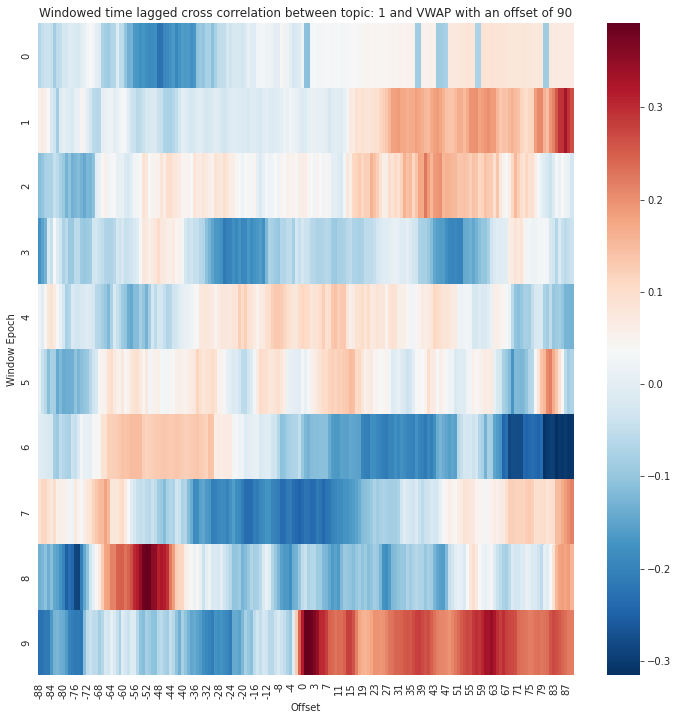

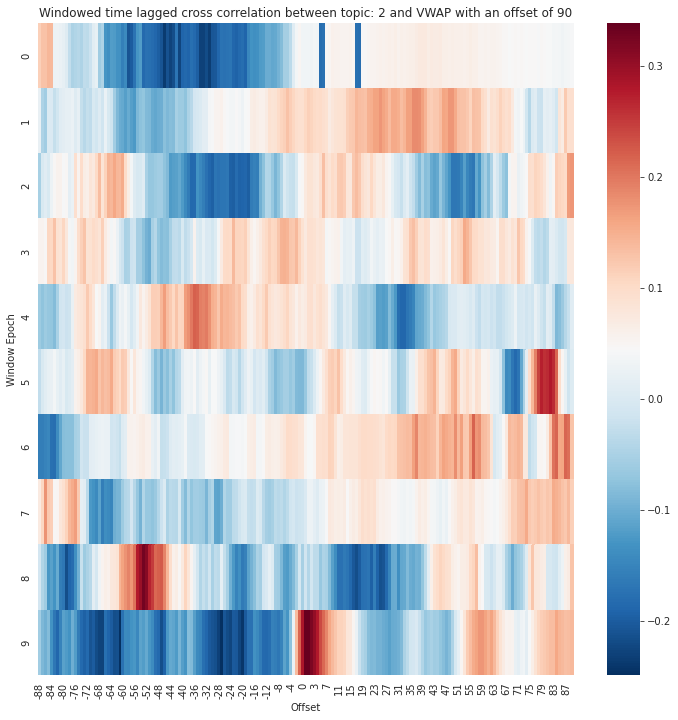

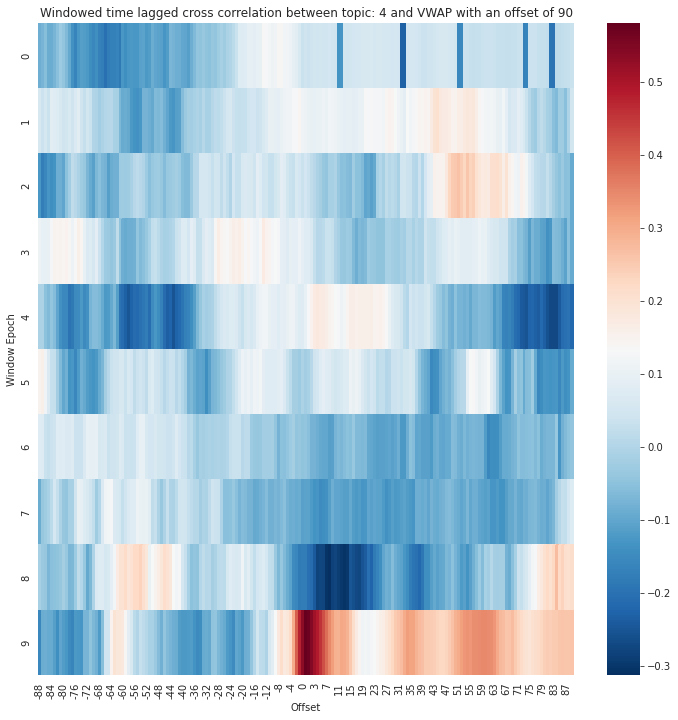

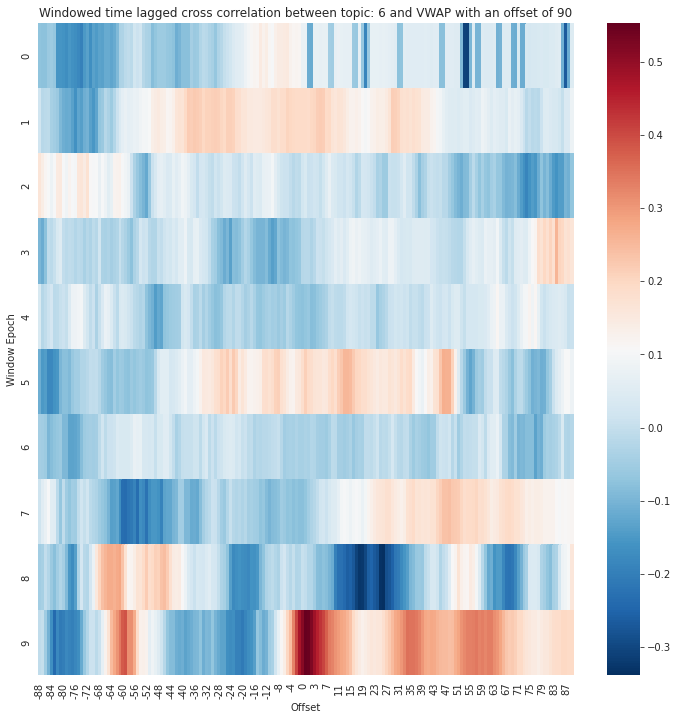

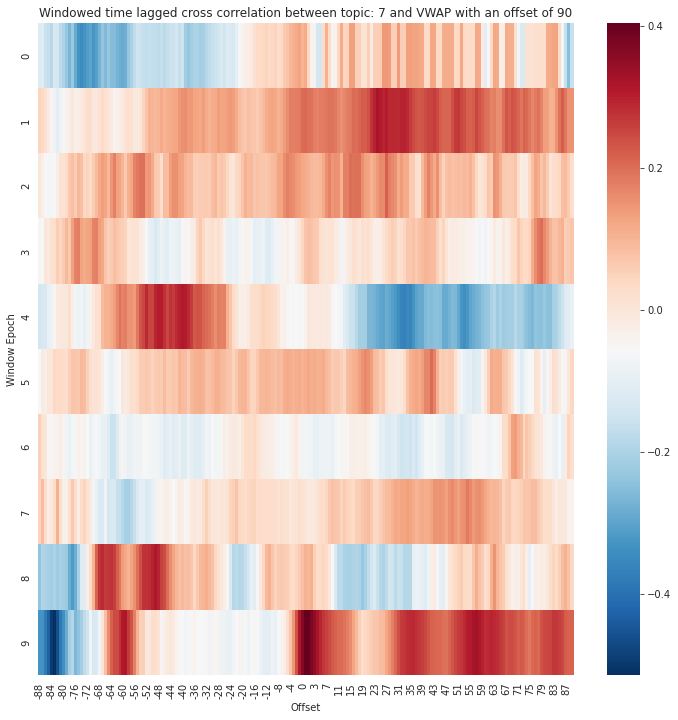

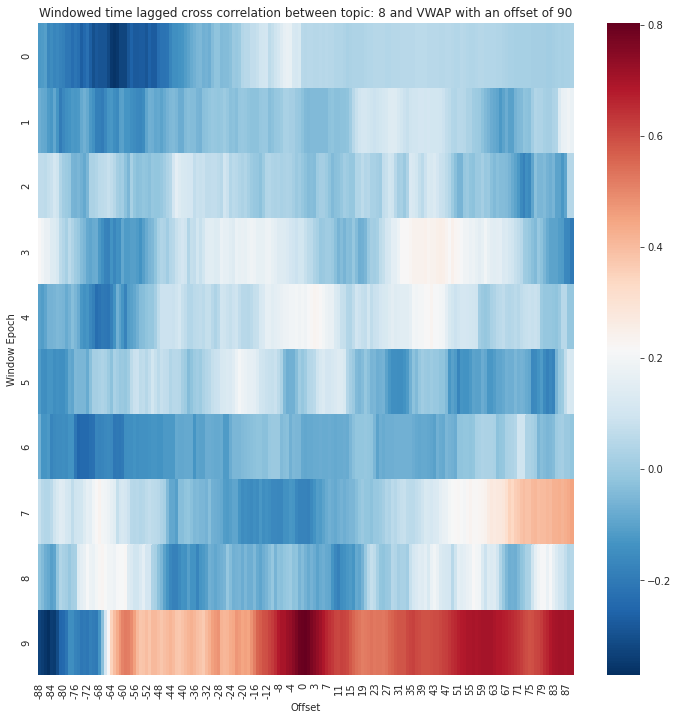

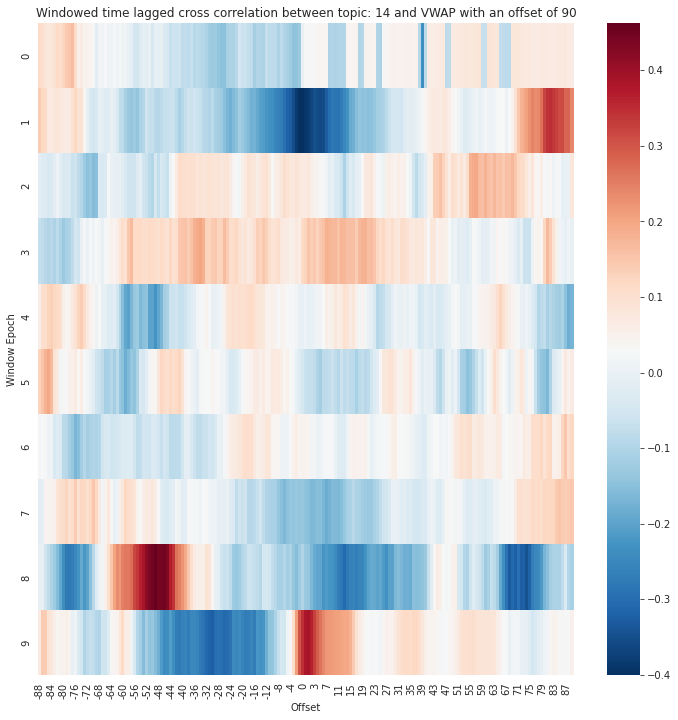

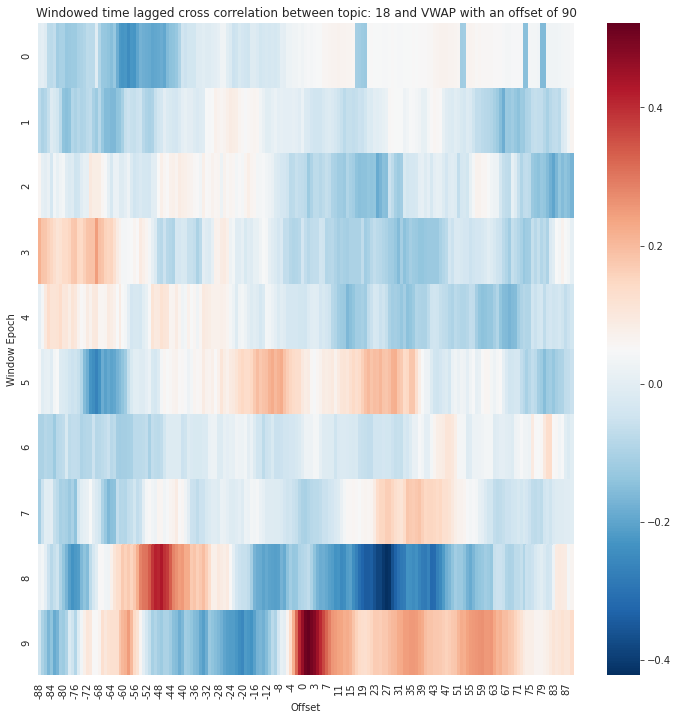

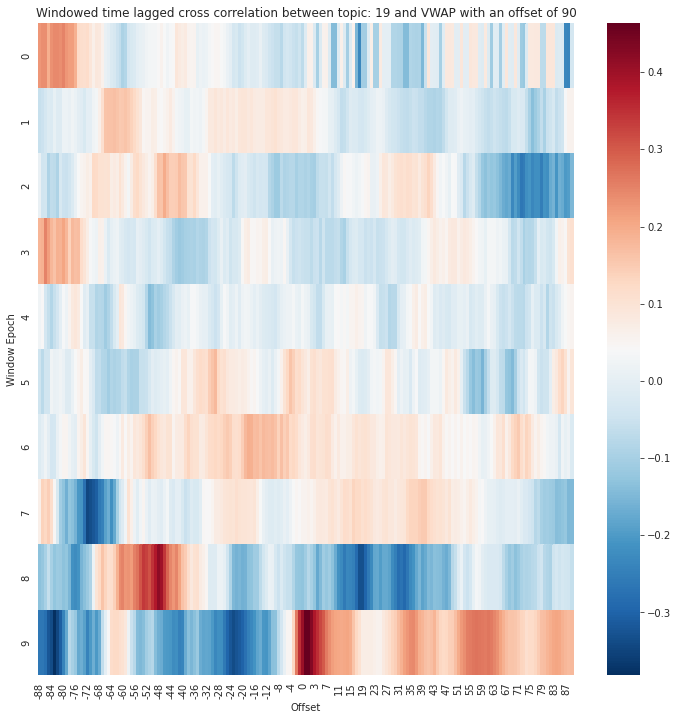

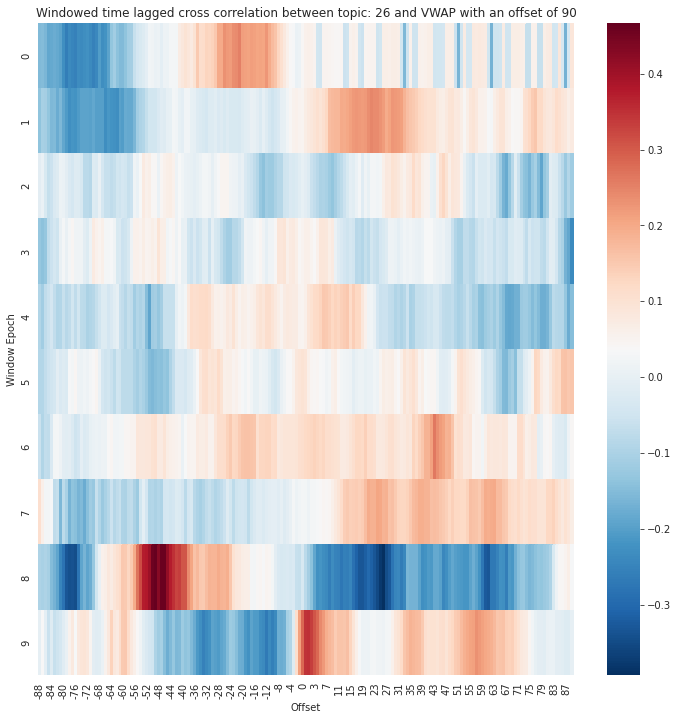

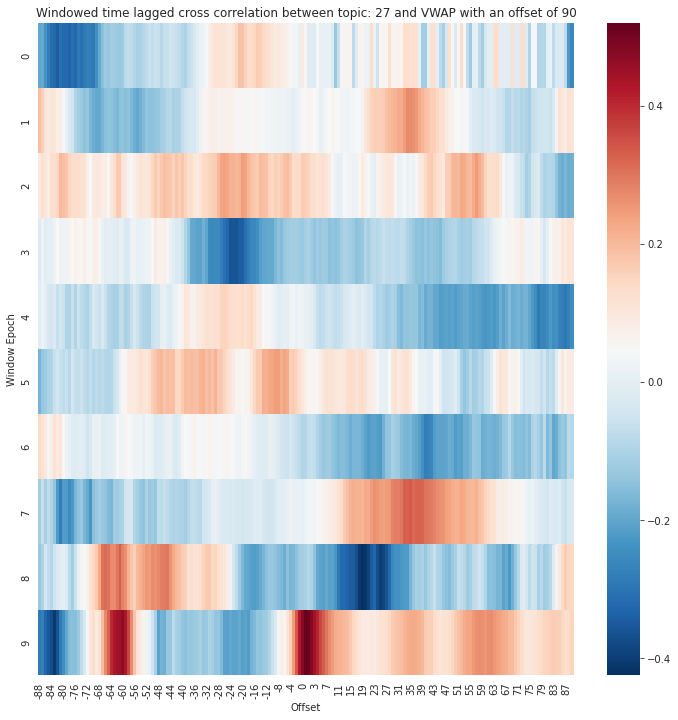

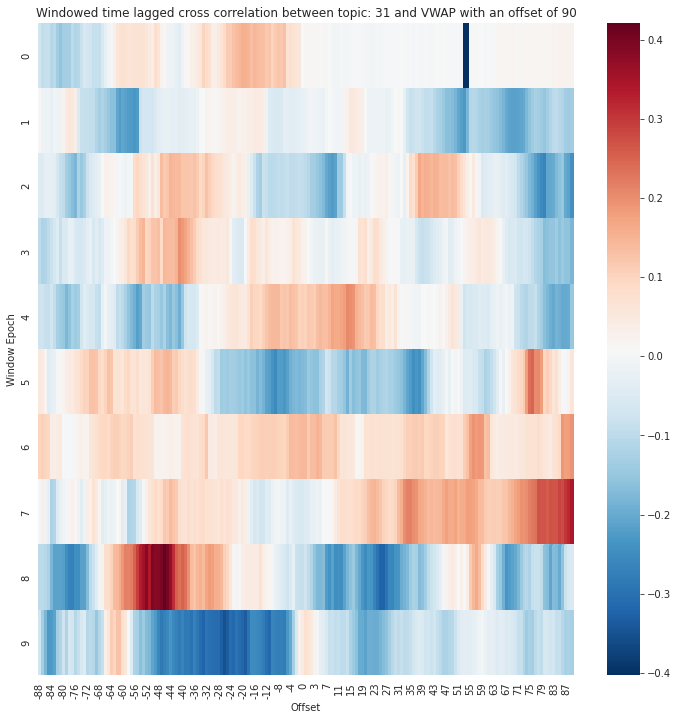

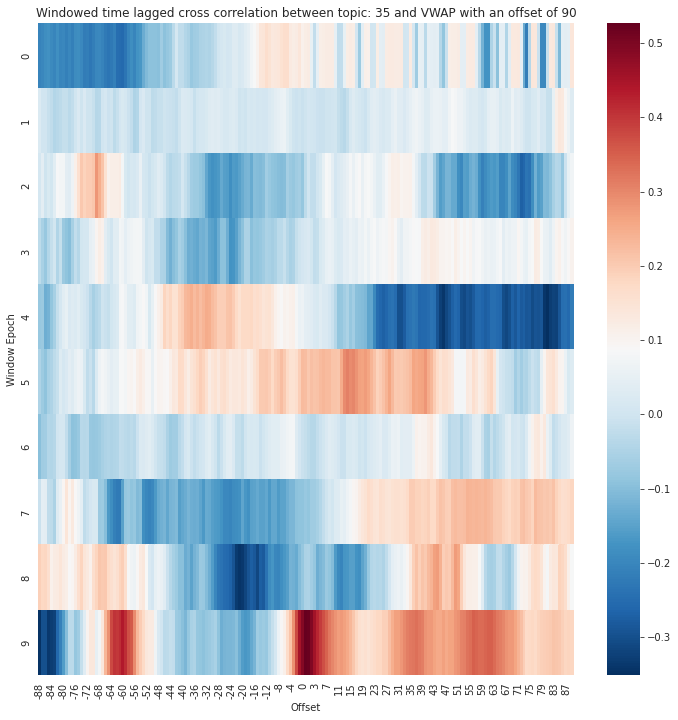

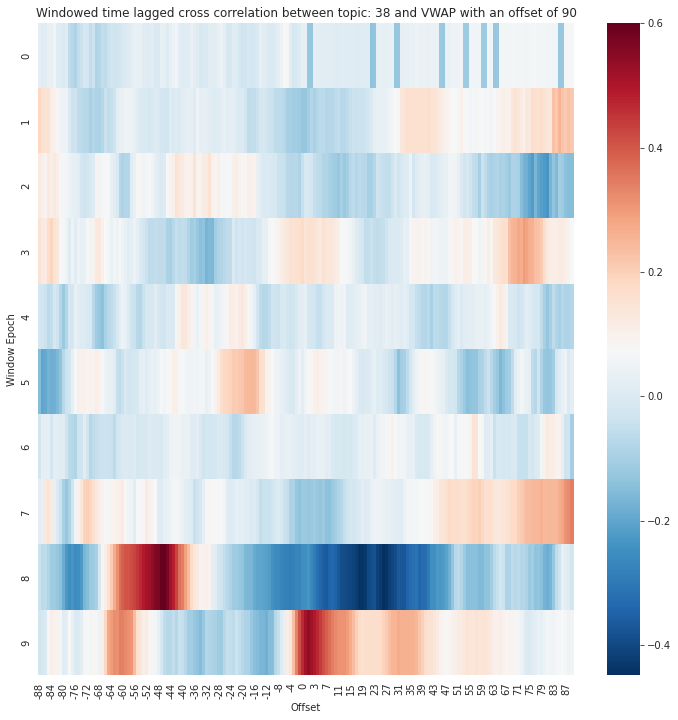

In [49]:
for item in keep_topics:
    wtlcc(merged, item, 'VWAP',no_splits=10, abs_bounds=90)

### WTLCC Results:

In the above figure we create splits of roughly 6 month windows of time to see if there were any leader follower relationships over a period of +- 90 days window.

While there are sporadic instances over each time period, the last two bands which make up 2020 and early 2021 are of particular interest. In the band representing early to mid 2020 topics 14, 18, 26, 31 and 38 all exhibit strong leadership behavior in early 2020 at around 48 days.

Similarly it is observed that topics 8, 27 and 35 leadership behavior to VWAP in the last 6 months with a lag period of around 60 days as well as strong positive synchrony with VWAP. The Synchrony shown in the WTLCC is a confirmation of the correlation observed between signals over the validation period.

The two periods of lagged leader behavior suggest momentum in stock price could have followed from the frequency of topics in early 2020 and late 2020.

In [50]:
def two_series_dtw(frame, col_1, col_2, metric='euclidean'):
    series_1 = frame[col_1].interpolate().values
    series_2 = frame[col_2].interpolate().values

    d, cost_matrix, acc_cost_matrix, path= accelerated_dtw(series_1, series_2, dist=metric)
    _, ax = plt.subplots(figsize=(10,10))
    ax.imshow(acc_cost_matrix.T, origin='lower', cmap='Greys', interpolation='nearest')
    ax.plot(path[0],path[1],'green')
    ax.set_xlabel(f'Topic {col_1}')
    ax.set_ylabel(f'{col_2}')
    ax.set_title(f'DTW Min path with min distance {d:.2f}')
    plt.show()

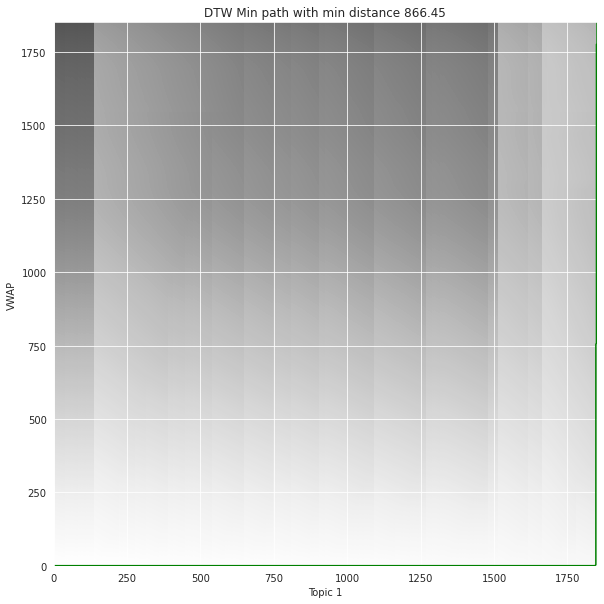

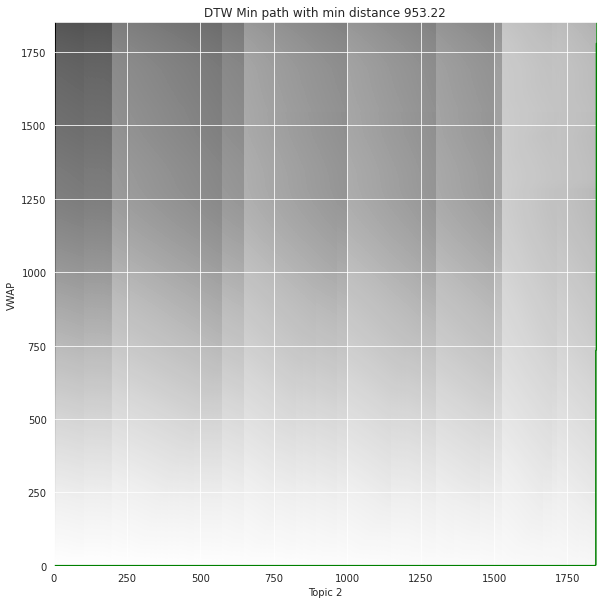

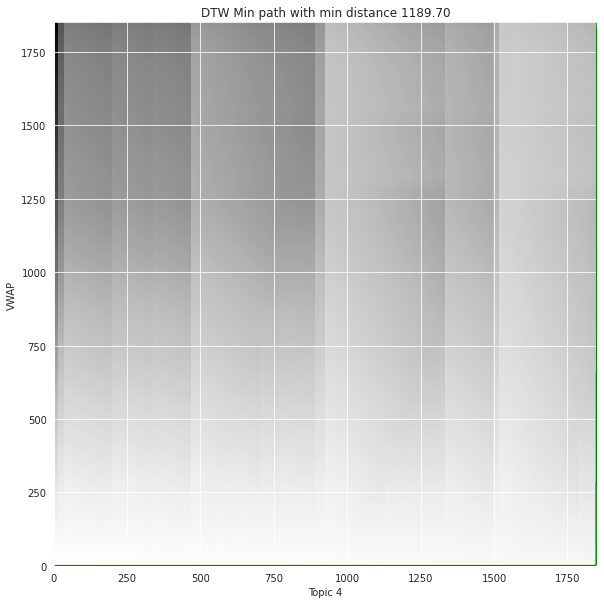

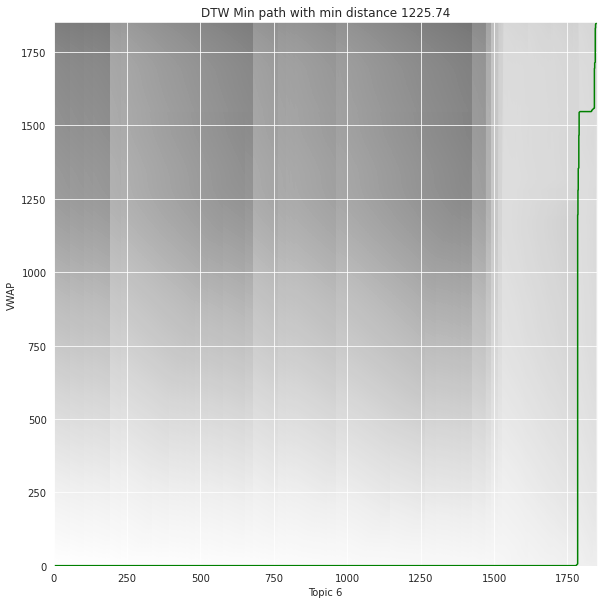

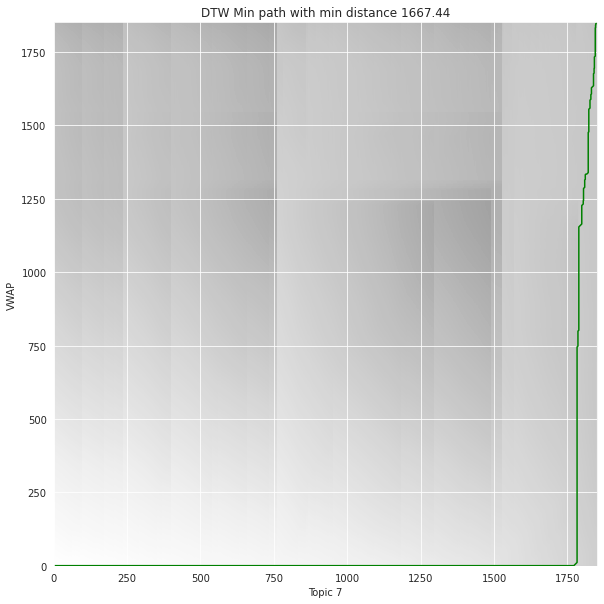

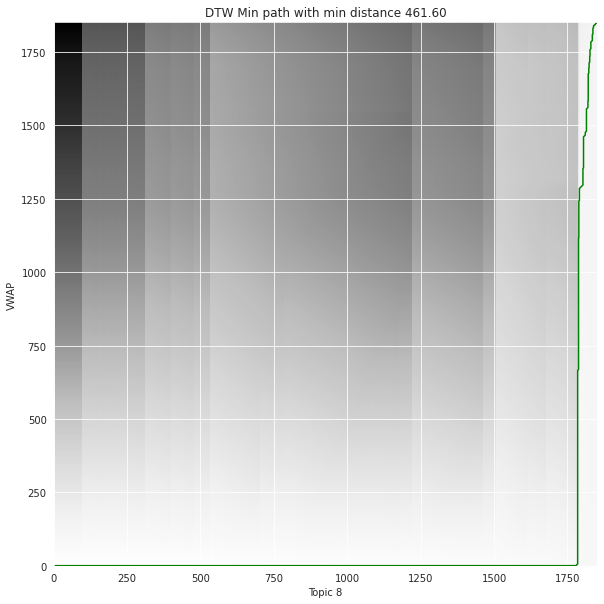

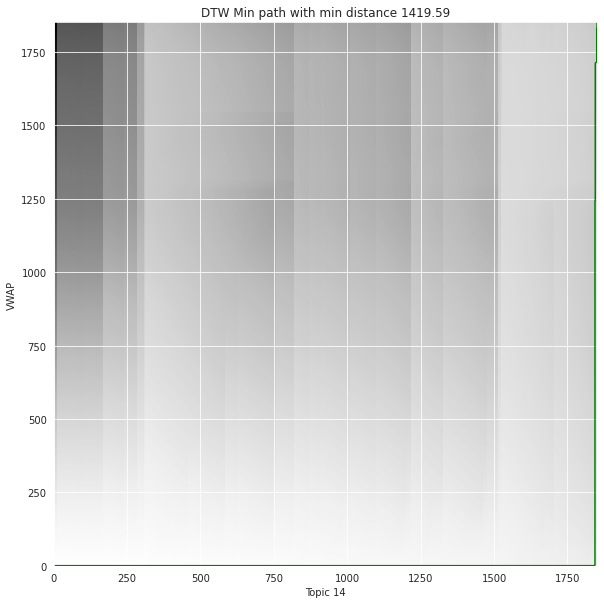

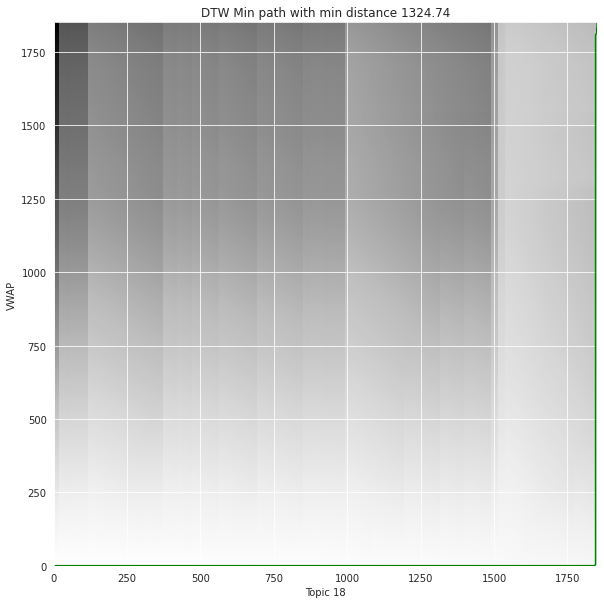

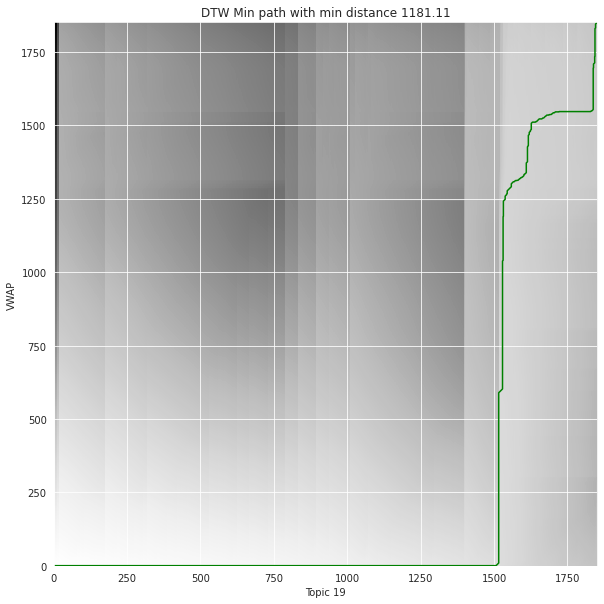

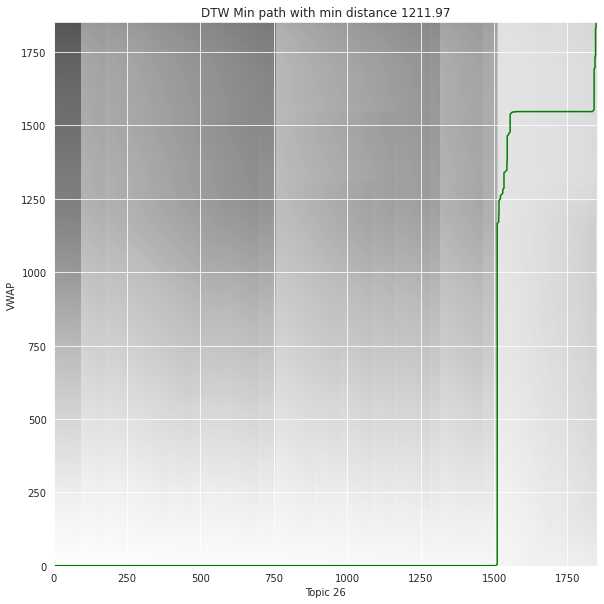

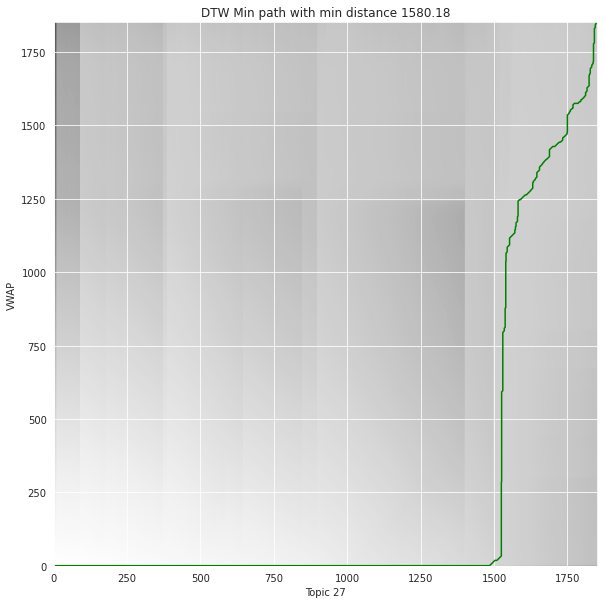

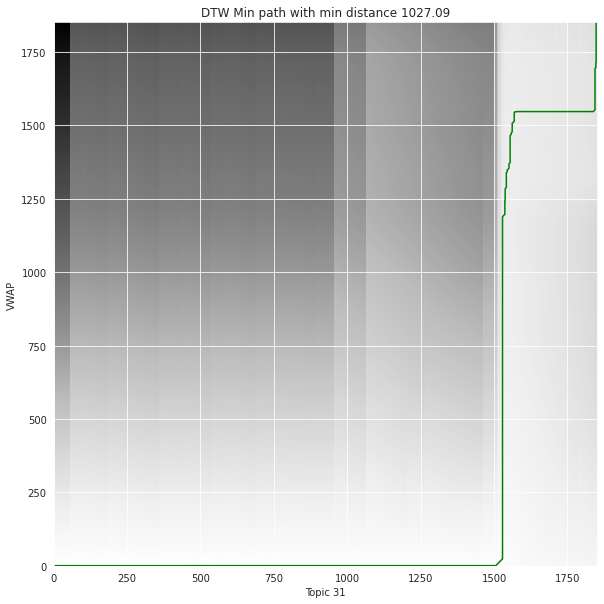

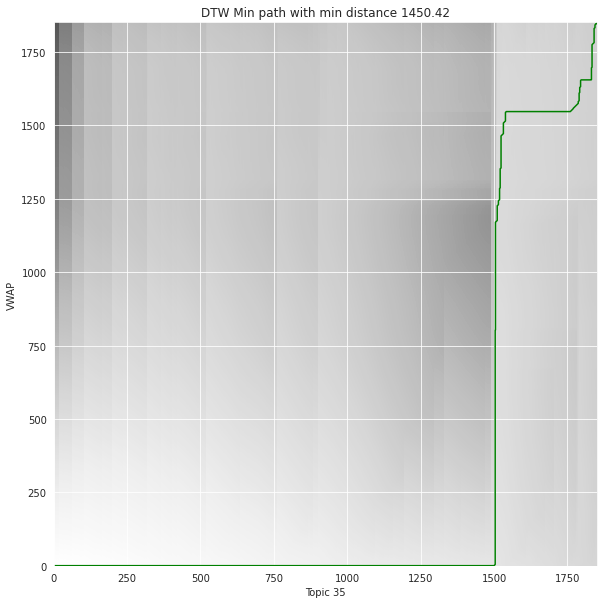

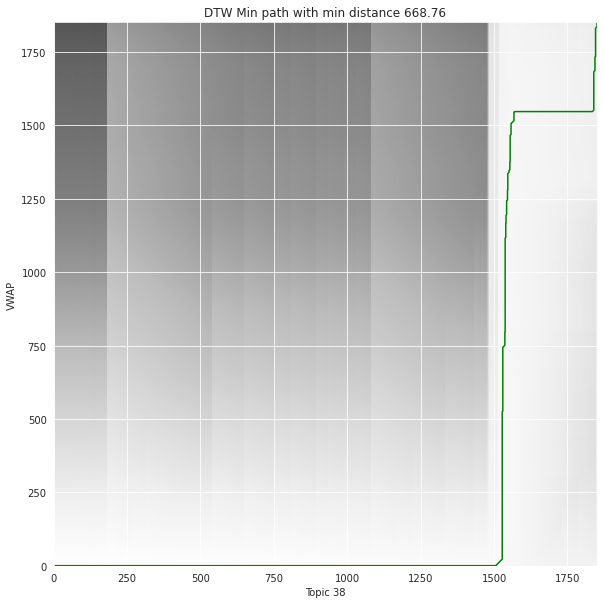

In [51]:
for item in keep_topics:
    two_series_dtw(merged, item, 'VWAP')

We see in the above figures interesting behavior where certain topics that showed unique leader/follower behavior have non-trival paths in roughly the last 6-12 months of data.

### RSI

Here we repeat the above tests but against the $GME RSI.

In [61]:
train_corrs = {item:np.corrcoef(merged.loc[:'2020-12-01'][item], merged.loc[:'2020-12-01']['RSI'])[0,1] for item in keep_topics}
train_corrs = {key:val for key, val in sorted(train_corrs.items(), key= lambda x: x[1], reverse=True)}
for key, val in train_corrs.items():
    print(f'topic {key} correlation with RSI: {val}')

topic 27 correlation with RSI: 0.1359921456411354
topic 35 correlation with RSI: 0.12705058502408748
topic 7 correlation with RSI: 0.11853639295673983
topic 31 correlation with RSI: 0.10813777277647414
topic 26 correlation with RSI: 0.10644272600023327
topic 6 correlation with RSI: 0.10603454445182138
topic 8 correlation with RSI: 0.10014940660006505
topic 19 correlation with RSI: 0.09129336291538885
topic 14 correlation with RSI: 0.08103272237309145
topic 2 correlation with RSI: 0.08087344920363063
topic 18 correlation with RSI: 0.07864326684889106
topic 38 correlation with RSI: 0.07612731874141657
topic 4 correlation with RSI: 0.05059362693305532
topic 1 correlation with RSI: 0.032184471123738276


In [62]:
val_corrs = {item:np.corrcoef(merged.loc['2020-12-01':][item], merged.loc['2020-12-01':]['RSI'])[0,1] for item in keep_topics}
val_corrs = {key:val for key, val in sorted(val_corrs.items(), key= lambda x: x[1], reverse=True)}
for key, val in train_corrs.items():
    print(f'topic {key} correlation with RSI: {val}')

topic 27 correlation with RSI: 0.1359921456411354
topic 35 correlation with RSI: 0.12705058502408748
topic 7 correlation with RSI: 0.11853639295673983
topic 31 correlation with RSI: 0.10813777277647414
topic 26 correlation with RSI: 0.10644272600023327
topic 6 correlation with RSI: 0.10603454445182138
topic 8 correlation with RSI: 0.10014940660006505
topic 19 correlation with RSI: 0.09129336291538885
topic 14 correlation with RSI: 0.08103272237309145
topic 2 correlation with RSI: 0.08087344920363063
topic 18 correlation with RSI: 0.07864326684889106
topic 38 correlation with RSI: 0.07612731874141657
topic 4 correlation with RSI: 0.05059362693305532
topic 1 correlation with RSI: 0.032184471123738276


In [63]:
glbl_corrs = {item:crosscorr(merged[item], merged['RSI']) for item in keep_topics}
glbl_corrs = {key:val for key, val in sorted(glbl_corrs.items(), key= lambda x: x[1], reverse=True)}
for key, val in train_corrs.items():
    print(f'topic {key} correlation with RSI: {val}')

topic 27 correlation with RSI: 0.1359921456411354
topic 35 correlation with RSI: 0.12705058502408748
topic 7 correlation with RSI: 0.11853639295673983
topic 31 correlation with RSI: 0.10813777277647414
topic 26 correlation with RSI: 0.10644272600023327
topic 6 correlation with RSI: 0.10603454445182138
topic 8 correlation with RSI: 0.10014940660006505
topic 19 correlation with RSI: 0.09129336291538885
topic 14 correlation with RSI: 0.08103272237309145
topic 2 correlation with RSI: 0.08087344920363063
topic 18 correlation with RSI: 0.07864326684889106
topic 38 correlation with RSI: 0.07612731874141657
topic 4 correlation with RSI: 0.05059362693305532
topic 1 correlation with RSI: 0.032184471123738276


#### WTLCC RSI

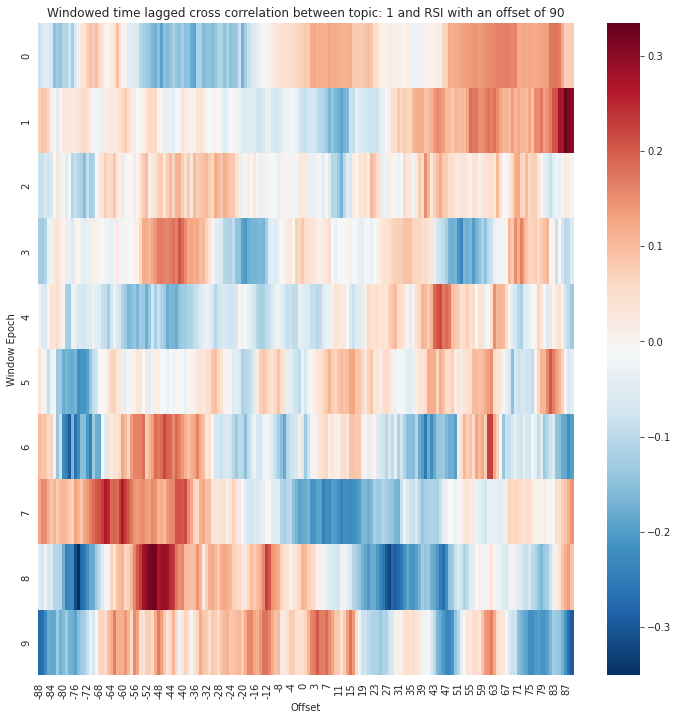

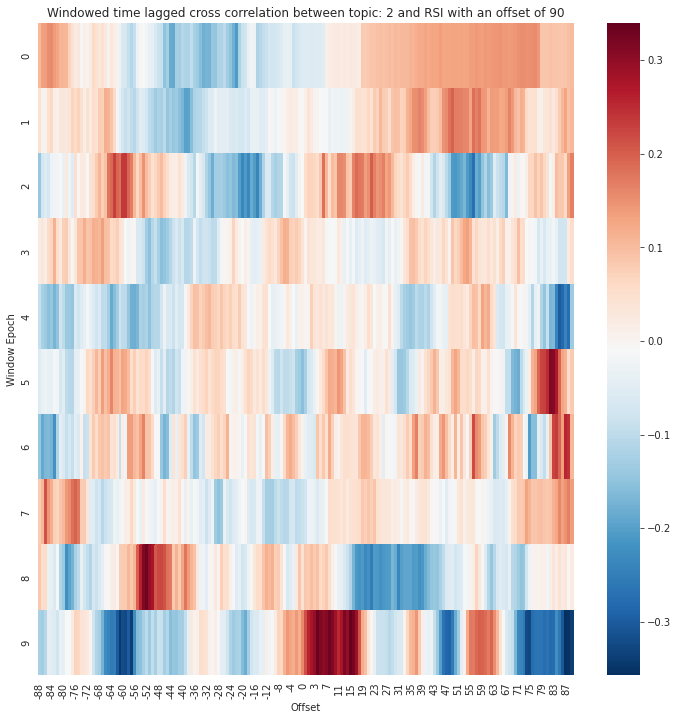

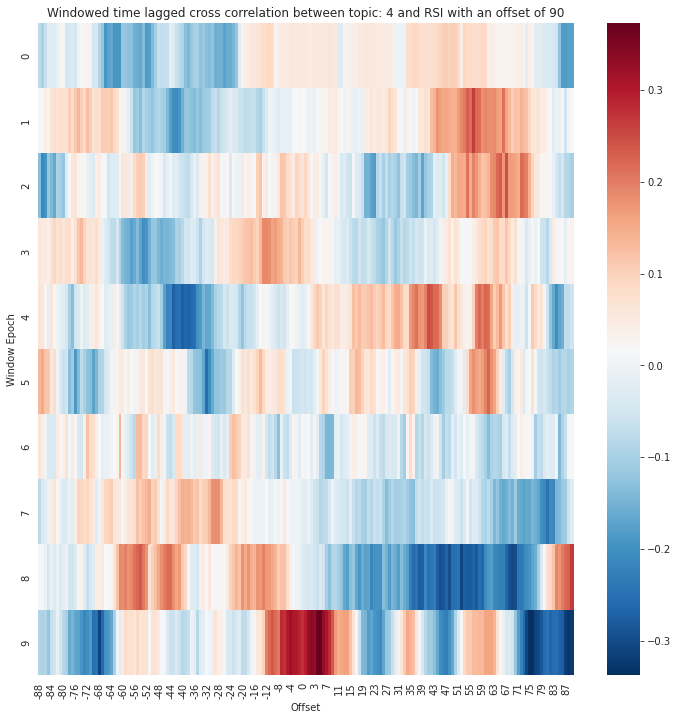

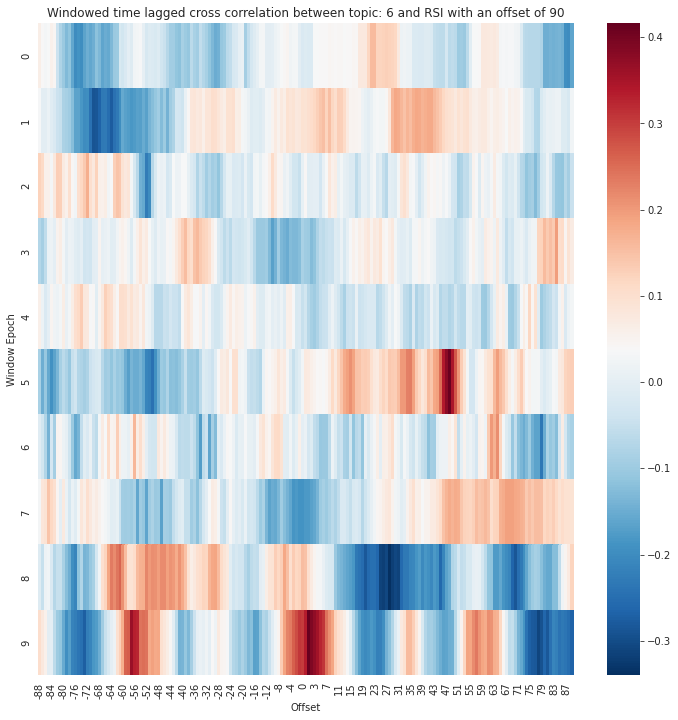

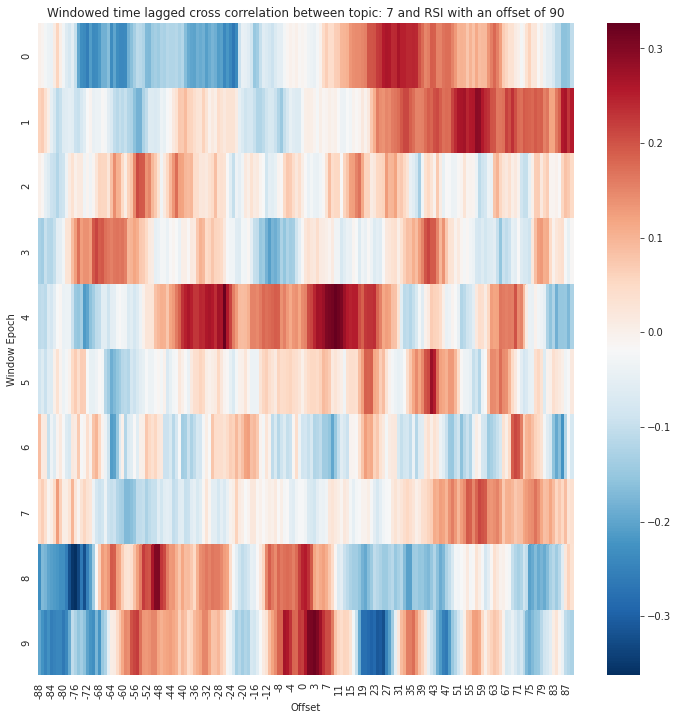

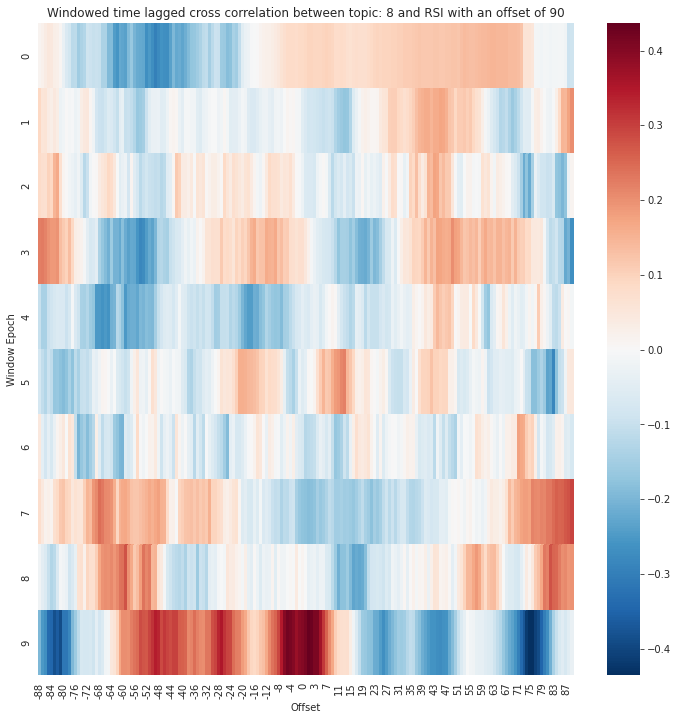

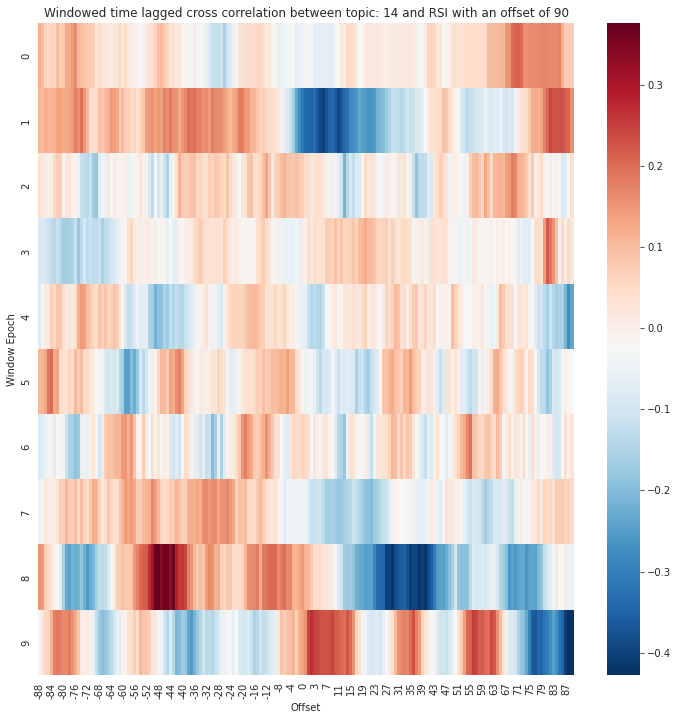

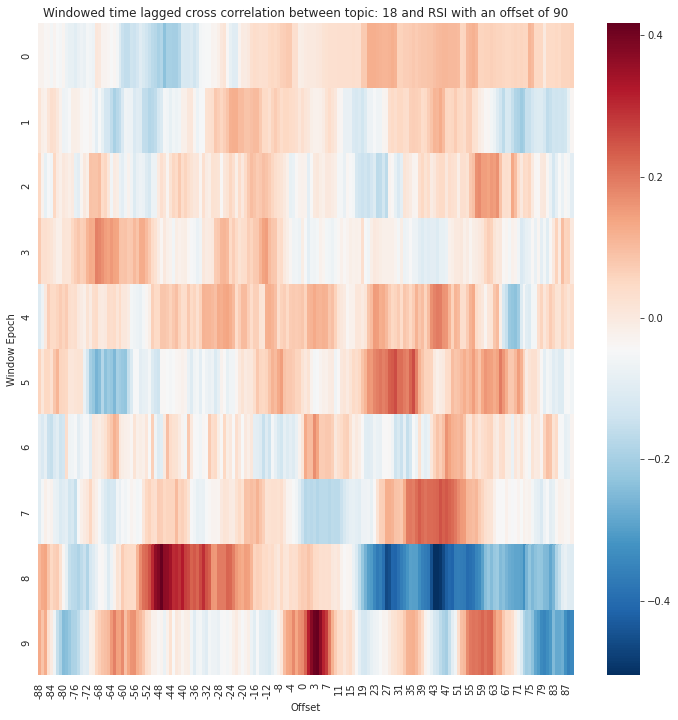

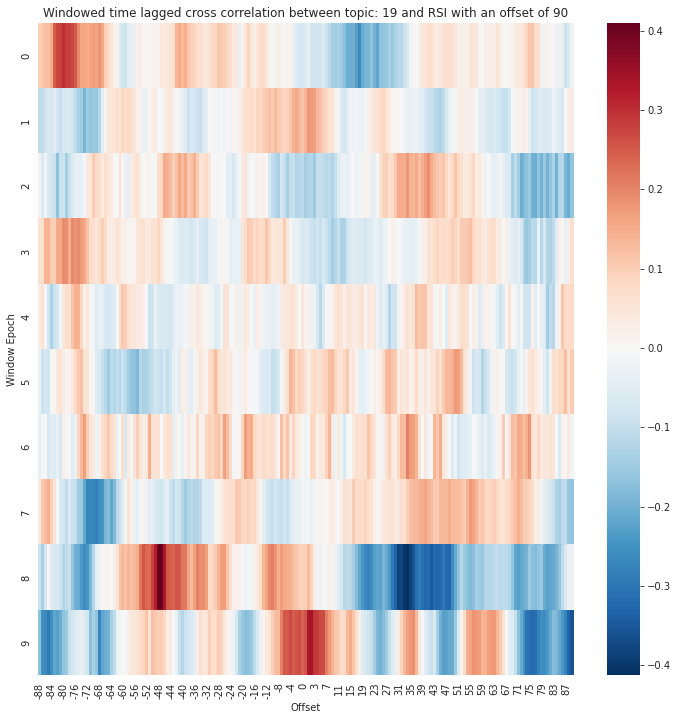

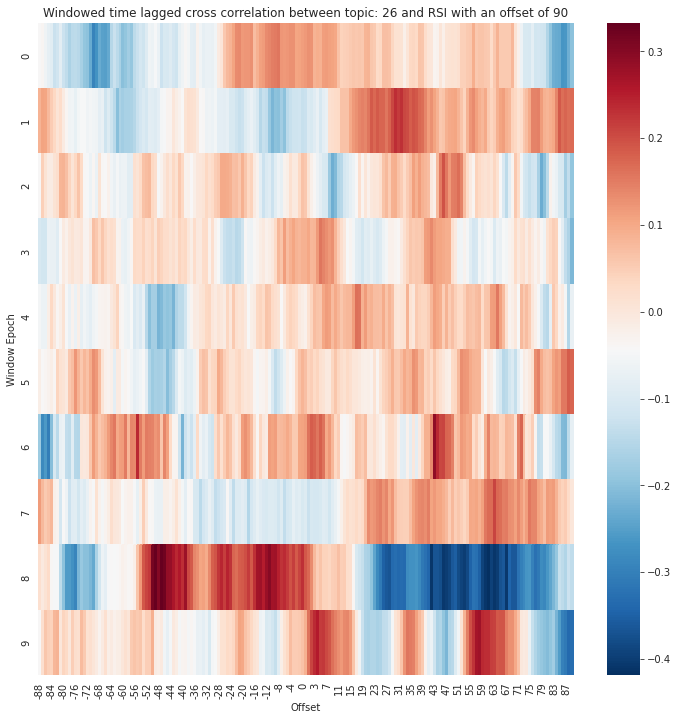

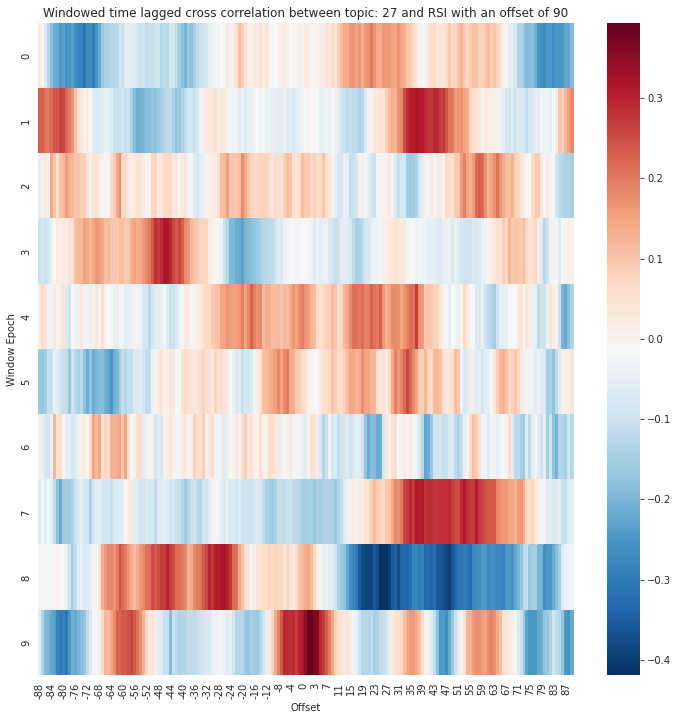

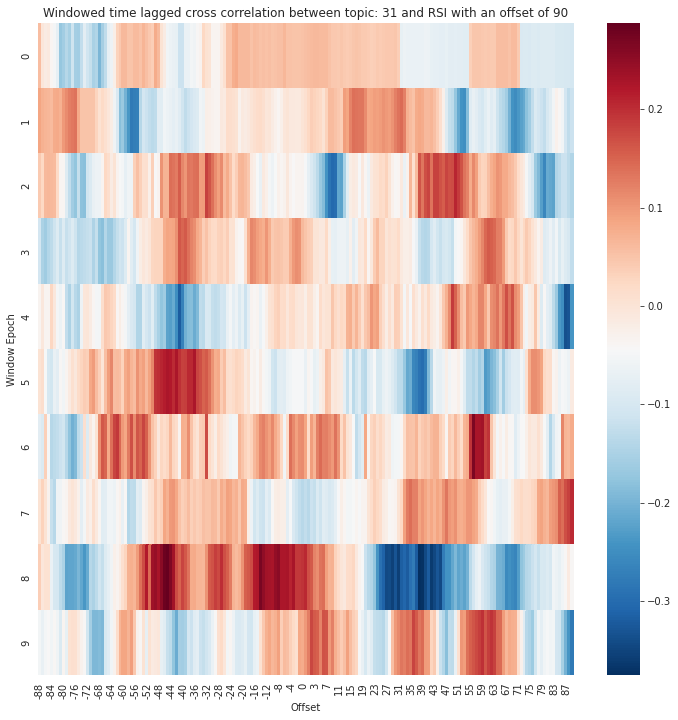

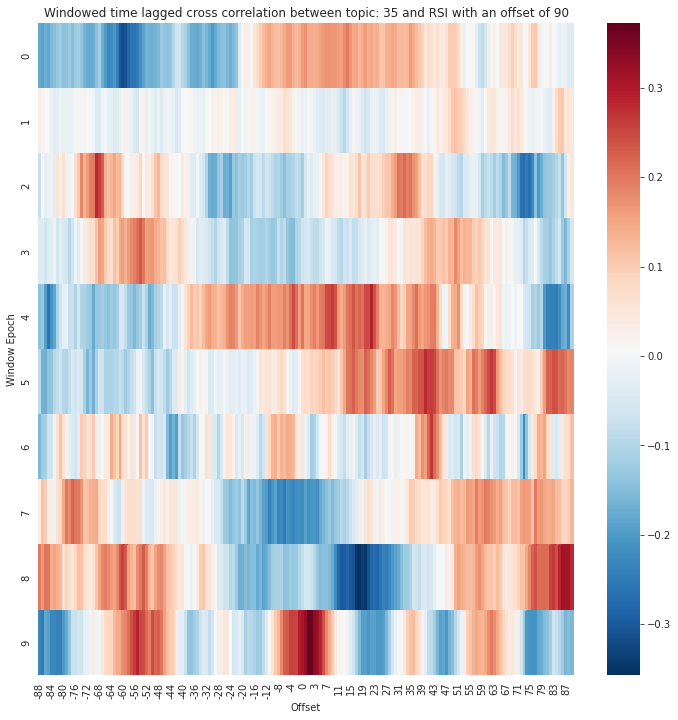

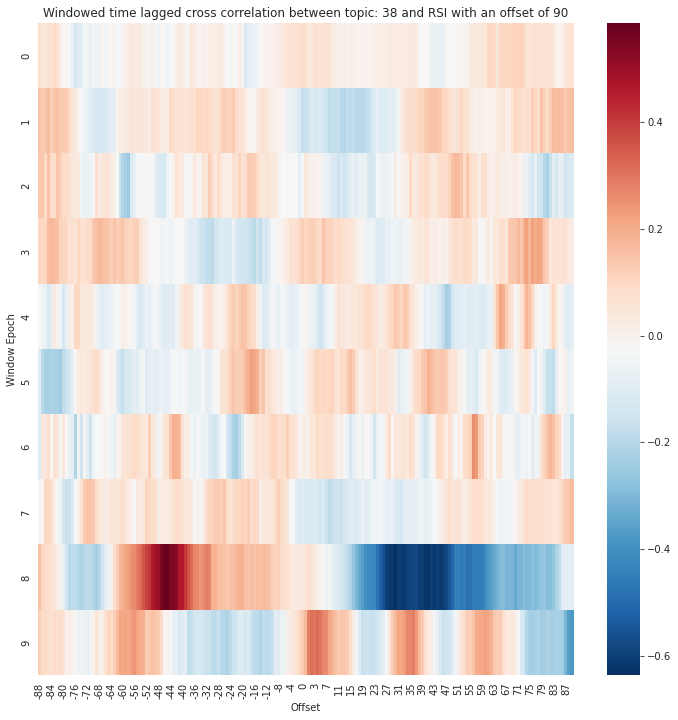

In [64]:
for item in keep_topics:
    wtlcc(merged, item, 'RSI',no_splits=10, abs_bounds=90)

#### DTW RSI

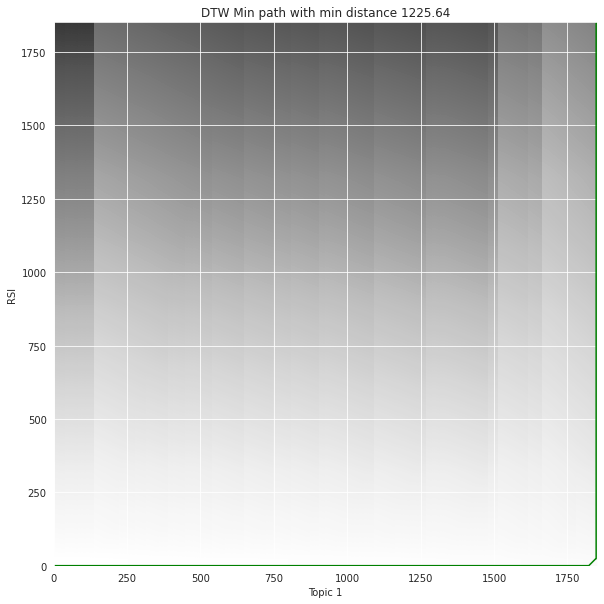

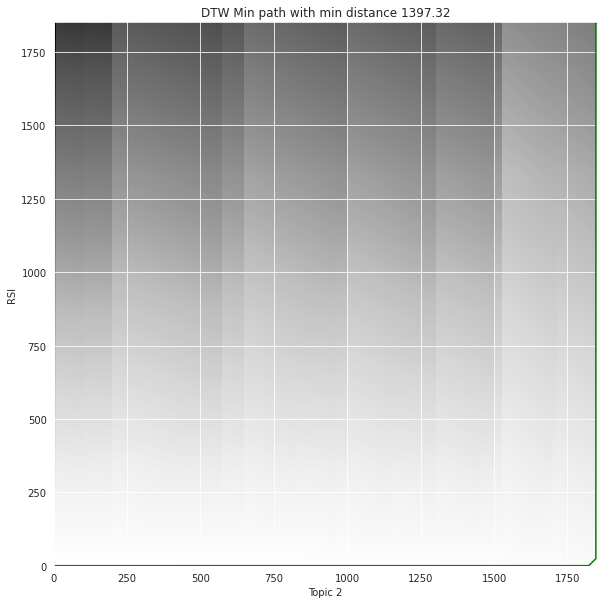

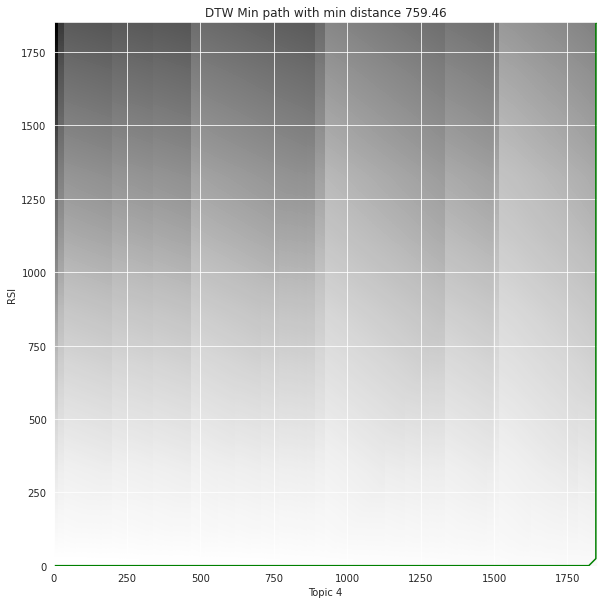

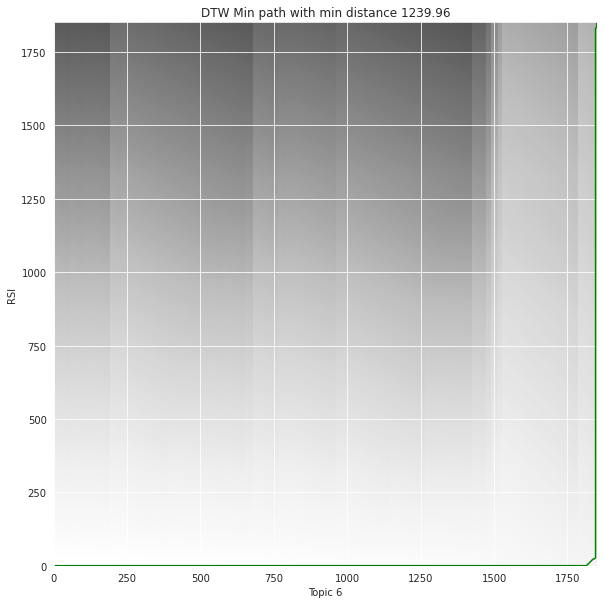

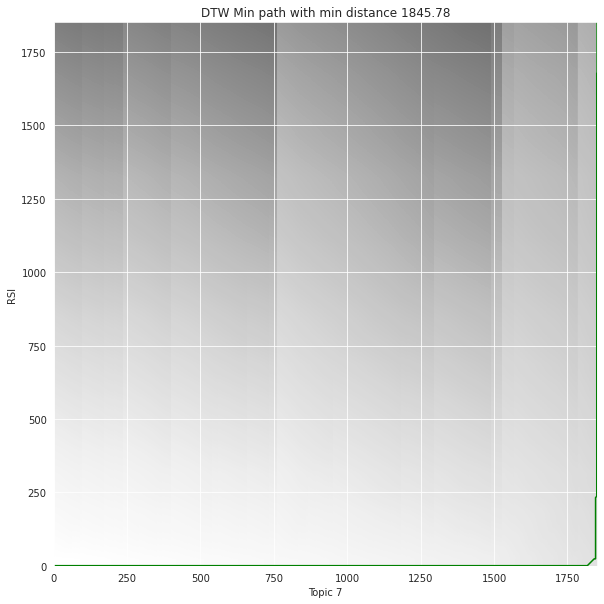

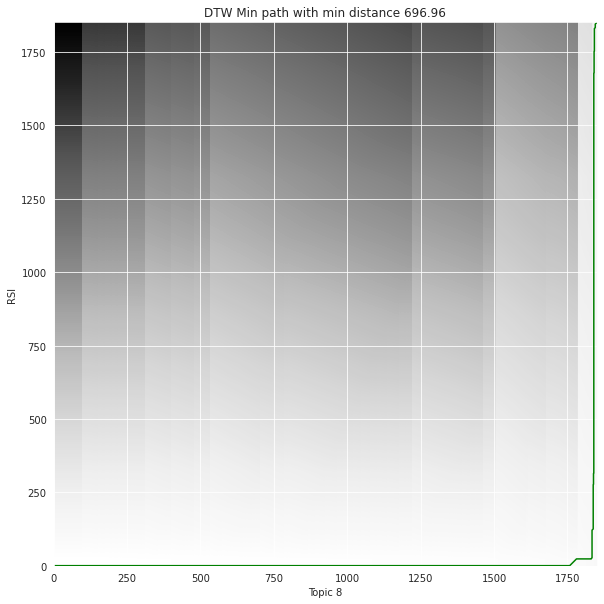

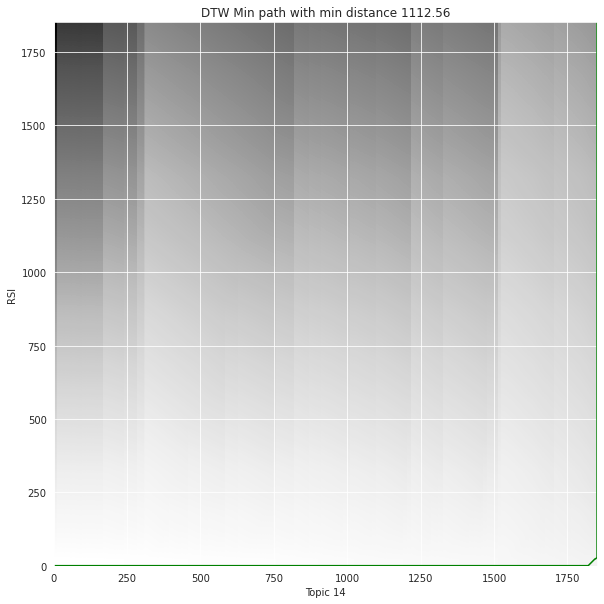

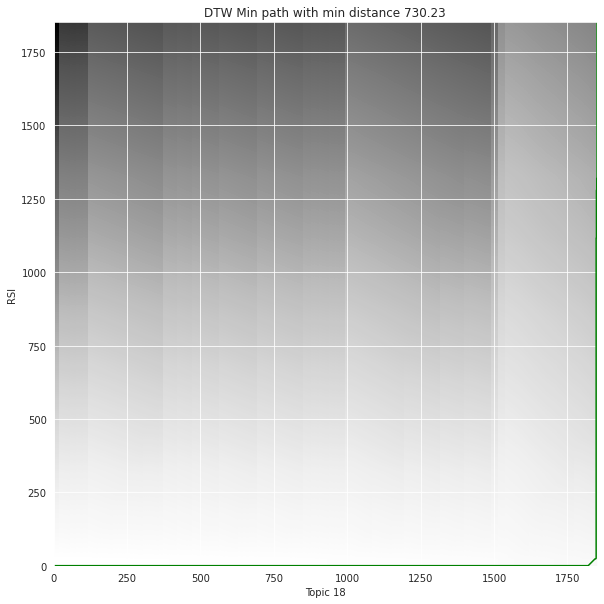

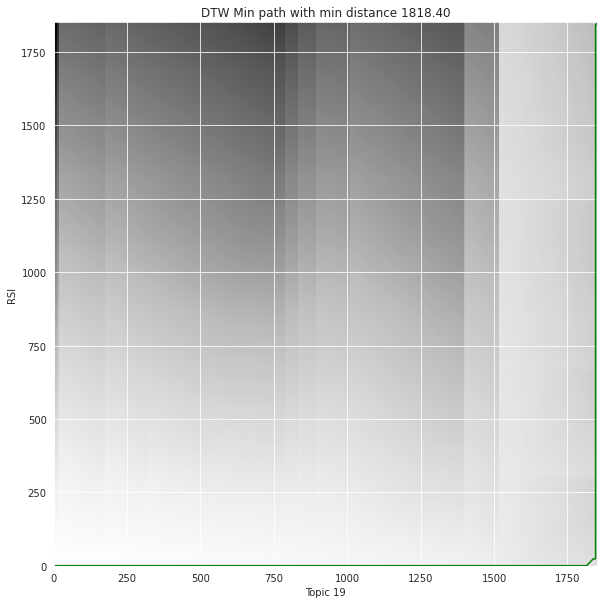

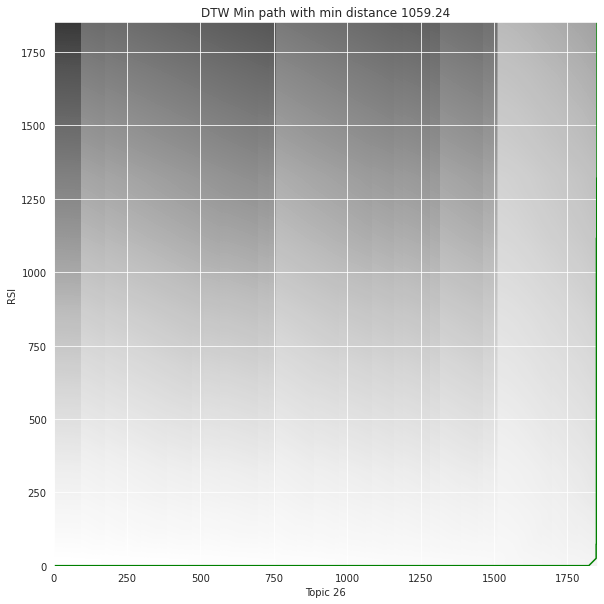

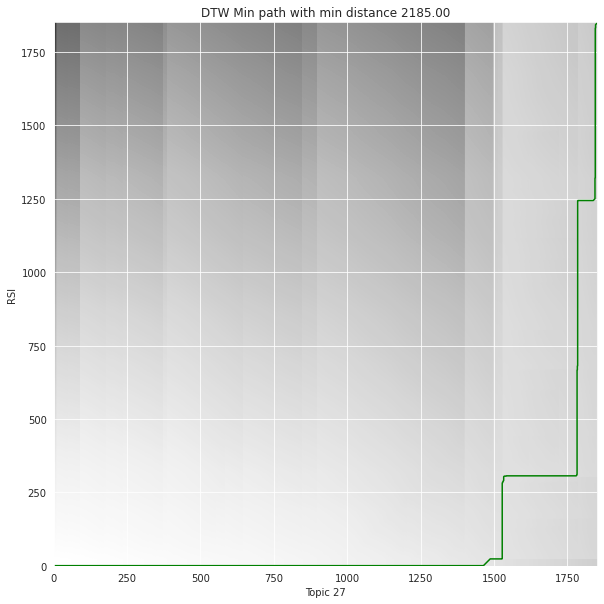

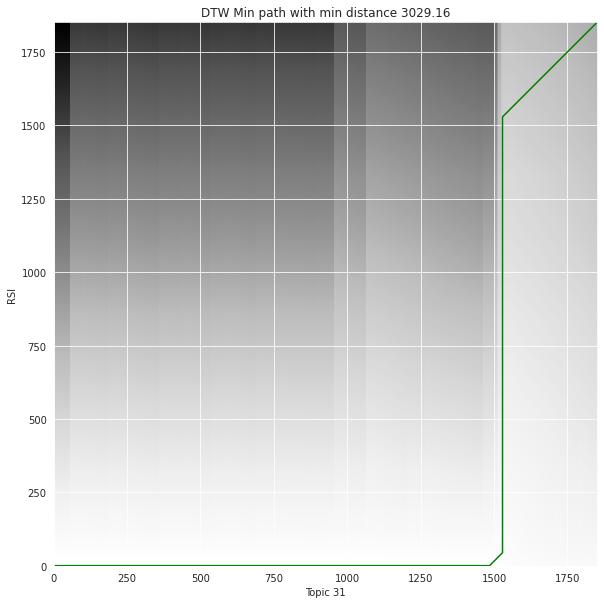

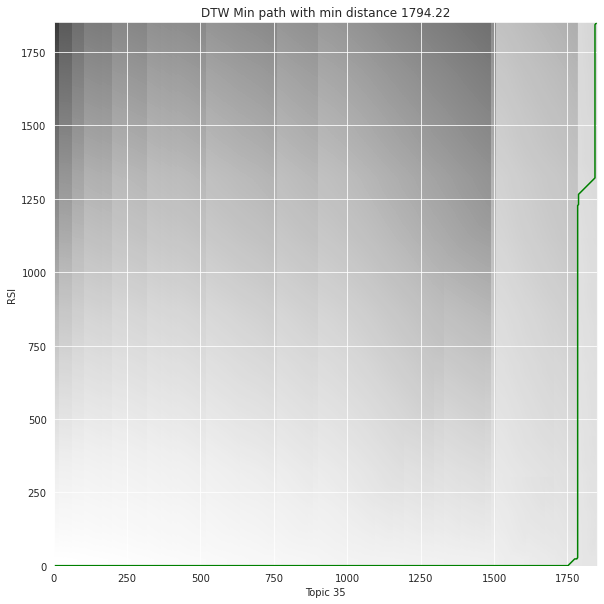

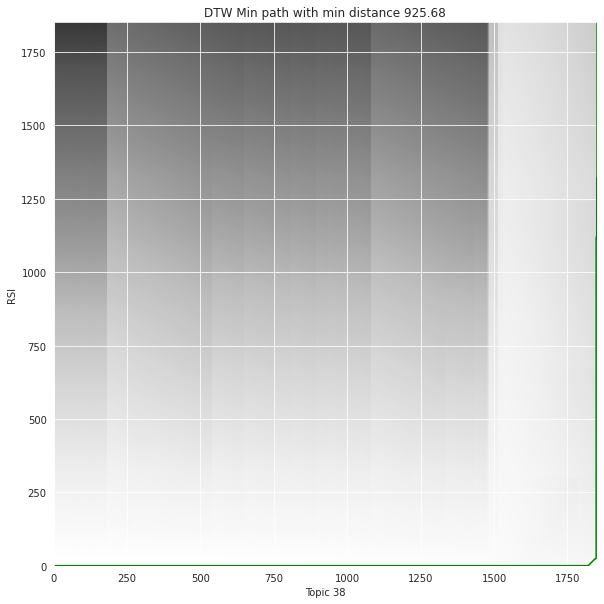

In [65]:
for item in keep_topics:
    two_series_dtw(merged, item, 'RSI')

We observe similar patterns in the relationship between topics and RSI and their resulting minimum paths between signals as with VWAP.

In [66]:
def adfuller_results(series, differencing = 0, mlag=None):
    
    if differencing == 0:
        res = adfuller(series, maxlag=mlag)
    elif differencing == 1:
        res = adfuller(series.diff().dropna(), maxlag=mlag)
    elif differencing == 2:
        res = adfuller(series.diff().diff().dropna(), maxlag=mlag)

    adf, pval, lags, nobs = res[0], res[1], res[2], res[3]
    diff_count=0
    if pval > 0.05:
        print(f'Series not stationary with p-value of: {pval}\n applying difference')
        pass
    else:
        print(f'Series is stationary with {differencing}-order differencing')
        print(f'adfuller statistic: {adf}')
        print(f'p-value: {pval}')
        print(f'number of lags used: {lags}')
        print(f'number of observations:{nobs}')
        print('critical values for stationarity\n',f'{res[4]}')

In [69]:
adfuller_results(merged['VWAP'], 1, 40)

Series is stationary with 1-order differencing
adfuller statistic: -3.827951235045567
p-value: 0.002633940523958711
number of lags used: 23
number of observations:1827
critical values for stationarity
 {'1%': -3.433934297502219, '5%': -2.8631232673540117, '10%': -2.5676128776645637}


In [70]:
adfuller_results(merged['RSI'],mlag=40)

Series is stationary with 0-order differencing
adfuller statistic: -8.20750507965512
p-value: 6.960436418199946e-13
number of lags used: 2
number of observations:1849
critical values for stationarity
 {'1%': -3.433891590943719, '5%': -2.8631044140606456, '10%': -2.5676028389397336}


In [120]:
adfuller_results(merged[7],1)

Series is stationary with 1-order differencing
adfuller statistic: -11.620186303231202
p-value: 2.3949075540958273e-21
number of lags used: 25
number of observations:1825
critical values for stationarity
 {'1%': -3.4339382310452033, '5%': -2.863125003847544, '10%': -2.56761380228936}


In [73]:
adfuller_results(merged[8],1)

Series is stationary with 1-order differencing
adfuller statistic: -5.905247380326046
p-value: 2.718279384089496e-07
number of lags used: 23
number of observations:1827
critical values for stationarity
 {'1%': -3.433934297502219, '5%': -2.8631232673540117, '10%': -2.5676128776645637}


In [76]:
adfuller_results(merged[27],1)

Series is stationary with 1-order differencing
adfuller statistic: -12.020242560203172
p-value: 3.0354024944681485e-22
number of lags used: 19
number of observations:1831
critical values for stationarity
 {'1%': -3.433926456232207, '5%': -2.863119805756803, '10%': -2.5676110344808043}


In [80]:
adfuller_results(merged[35],1)

Series is stationary with 1-order differencing
adfuller statistic: -7.7811939137356685
p-value: 8.408597777490656e-12
number of lags used: 25
number of observations:1825
critical values for stationarity
 {'1%': -3.4339382310452033, '5%': -2.863125003847544, '10%': -2.56761380228936}


In [92]:
adfuller_results(merged[14],1)

Series is stationary with 1-order differencing
adfuller statistic: -9.685430026568293
p-value: 1.1740589647170755e-16
number of lags used: 25
number of observations:1825
critical values for stationarity
 {'1%': -3.4339382310452033, '5%': -2.863125003847544, '10%': -2.56761380228936}


In [95]:
adfuller_results(merged[26],1)

Series is stationary with 1-order differencing
adfuller statistic: -11.655155775054743
p-value: 1.9936116174410343e-21
number of lags used: 20
number of observations:1830
critical values for stationarity
 {'1%': -3.433928413331545, '5%': -2.8631206697362663, '10%': -2.567611494520589}


In [96]:
adfuller_results(merged[31],1)

Series is stationary with 1-order differencing
adfuller statistic: -10.321225167448635
p-value: 3.0054280706946136e-18
number of lags used: 25
number of observations:1825
critical values for stationarity
 {'1%': -3.4339382310452033, '5%': -2.863125003847544, '10%': -2.56761380228936}


In [99]:
adfuller_results(merged[38],1)

Series is stationary with 1-order differencing
adfuller statistic: -25.788591791306736
p-value: 0.0
number of lags used: 6
number of observations:1844
critical values for stationarity
 {'1%': -3.4339012073737605, '5%': -2.8631086593659174, '10%': -2.567605099413705}


Having tested a number of the signals of interest, all are stationary with first order differencing.

### Granger causality:

Given the results from the above graphical explorations of trends and correlations in the datasets. There is interesting behavior to be found in the relationship between topic number 22 and both the RSI and VWAP for GameStop in the final 6 month split of the data, we see in both instances the same leader influence. So the question can be raised: "Were gamestop stock prices granger caused by the number of posts and comments about short-squeezing the stock?"

Here we try to answer that question with granger-causality tests: essentiall trying to say whether or not the daily frequence of short squeeze references would have served as a predictor of price.

To begin we first test the relationship in one direction:

null hypothesis: The daily frequencies of short squeeze posts do not increase stock prices.

alternatice: They do.



#### Topic #8

In [116]:
grangercausalitytests(merged[[8,'VWAP']].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9466  , p=0.3307  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.9481  , p=0.3302  , df=1
likelihood ratio test: chi2=0.9479  , p=0.3303  , df=1
parameter F test:         F=0.9466  , p=0.3307  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8513  , p=0.4270  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=1.7073  , p=0.4259  , df=2
likelihood ratio test: chi2=1.7065  , p=0.4260  , df=2
parameter F test:         F=0.8513  , p=0.4270  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2976  , p=0.0012  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=15.9532 , p=0.0012  , df=3
likelihood ratio test: chi2=15.8847 , p=0.0012  , df=3
parameter F test:         F=5.2976  , p=0.0012  , df_denom=1841, df_num=3


{1: ({'lrtest': (0.9478876524403859, 0.33025756063430667, 1),
   'params_ftest': (0.9465930203592232, 0.33071543135548565, 1847.0, 1.0),
   'ssr_chi2test': (0.9481305293245145, 0.3301956118995522, 1),
   'ssr_ftest': (0.9465930203580423, 0.33071543135580006, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (1.7064626454875906, 0.4260360453716592, 2),
   'params_ftest': (0.8513168294181357, 0.4270201637532125, 1844.0, 2.0),
   'ssr_chi2test': (1.7072503444612752, 0.4258682843322815, 2),
   'ssr_ftest': (0.8513168294176829, 0.42702016375338747, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (15.88473992885065, 0.0011973823632666627, 3),
   'params_ftest': (5.297592296252005, 0.001229370748627839, 1841.0, 3.0),
   'ssr_chi2test': (15.953205698219218, 0.0011593109926818382, 3),
   'ssr_ftest': (5.2975922962520885, 0.0012293707486276918, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
    

We see that after just 3 lags there the resulting significance levels of the different tests suggest that the topic frequencies do increase price.

The next step is to test the converse:

To begin we first test the relationship in one direction:

null hypothesis: Stock price increase does not influence the number of daily postings about shorting gamestop stocks.

alternatice: Price does have an influence.


In this instance we are looking for significance at the same lag number as before. Since this is an iff type "proof" both directions must be valid for the initial assumption, i.e. if we find both to be a cause for the other that is bad.

In [117]:
grangercausalitytests(merged[['VWAP',8]].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1039  , p=0.7473  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.1040  , p=0.7470  , df=1
likelihood ratio test: chi2=0.1040  , p=0.7470  , df=1
parameter F test:         F=0.1039  , p=0.7473  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.3910  , p=0.0001  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=18.8329 , p=0.0001  , df=2
likelihood ratio test: chi2=18.7376 , p=0.0001  , df=2
parameter F test:         F=9.3910  , p=0.0001  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.5429  , p=0.0009  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=16.6918 , p=0.0008  , df=3
likelihood ratio test: chi2=16.6169 , p=0.0008  , df=3
parameter F test:         F=5.5429  , p=0.0009  , df_denom=1841, df_num=3


{1: ({'lrtest': (0.10403139806294348, 0.7470444072249229, 1),
   'params_ftest': (0.10386561881794194, 0.7472756225961366, 1847.0, 1.0),
   'ssr_chi2test': (0.10403432312456266, 0.7470409726786944, 1),
   'ssr_ftest': (0.1038656188167931, 0.7472756225973414, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (18.737638234599217, 8.534411032127833e-05, 2),
   'params_ftest': (9.390987732060445, 8.753391059252207e-05, 1844.0, 2.0),
   'ssr_chi2test': (18.832902729479088, 8.13742751713649e-05, 2),
   'ssr_ftest': (9.39098773206042, 8.753391059252207e-05, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (16.61690753419316, 0.0008472340738065644, 3),
   'params_ftest': (5.542871173943406, 0.000870982852453337, 1841.0, 3.0),
   'ssr_chi2test': (16.691840189213536, 0.0008177276710168994, 3),
   'ssr_ftest': (5.542871173943383, 0.000870982852453337, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],

In the case of topic#8 we can reject the null hypothesis in both directions therefore we cannot say that this topic granger caused gme price increase.

#### Topic #27

In [115]:
grangercausalitytests(merged[[27,'VWAP']].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9151  , p=0.1666  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=1.9182  , p=0.1661  , df=1
likelihood ratio test: chi2=1.9172  , p=0.1662  , df=1
parameter F test:         F=1.9151  , p=0.1666  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9545  , p=0.1419  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=3.9196  , p=0.1409  , df=2
likelihood ratio test: chi2=3.9155  , p=0.1412  , df=2
parameter F test:         F=1.9545  , p=0.1419  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.0034  , p=0.0005  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=18.0787 , p=0.0004  , df=3
likelihood ratio test: chi2=17.9909 , p=0.0004  , df=3
parameter F test:         F=6.0034  , p=0.0005  , df_denom=1841, df_num=3


{1: ({'lrtest': (1.917216123703838, 0.16616387824526768, 1),
   'params_ftest': (1.9150992935219548, 0.16656512306711577, 1847.0, 1.0),
   'ssr_chi2test': (1.9182099041773943, 0.1660541337766116, 1),
   'ssr_ftest': (1.9150992935219715, 0.16656512306711577, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (3.915465008390129, 0.14117817918783349, 2),
   'params_ftest': (1.9545071874059343, 0.14192756266329395, 1844.0, 2.0),
   'ssr_chi2test': (3.9196136545707163, 0.14088563355287884, 2),
   'ssr_ftest': (1.9545071874062738, 0.14192756266324916, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (17.99087442242626, 0.0004417599125753288, 3),
   'params_ftest': (6.00341757568508, 0.0004552362107900964, 1841.0, 3.0),
   'ssr_chi2test': (18.07873277544718, 0.00042370597528617715, 3),
   'ssr_ftest': (6.003417575685111, 0.0004552362107900964, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
    

In [85]:
grangercausalitytests(merged[['VWAP',27]].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6036  , p=0.4373  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.6046  , p=0.4368  , df=1
likelihood ratio test: chi2=0.6045  , p=0.4369  , df=1
parameter F test:         F=0.6036  , p=0.4373  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8909  , p=0.0558  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=5.7975  , p=0.0551  , df=2
likelihood ratio test: chi2=5.7885  , p=0.0553  , df=2
parameter F test:         F=2.8909  , p=0.0558  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1287  , p=0.0947  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=6.4103  , p=0.0933  , df=3
likelihood ratio test: chi2=6.3992  , p=0.0937  , df=3
parameter F test:         F=2.1287  , p=0.0947  , df_denom=1841, df_num=3


{1: ({'lrtest': (0.6044945902976906, 0.43686825660697404, 1),
   'params_ftest': (0.6036129398493562, 0.43730232474857256, 1847.0, 1.0),
   'ssr_chi2test': (0.6045933615152281, 0.4368307980133107, 1),
   'ssr_ftest': (0.6036129398479061, 0.4373023247491955, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (5.788473220802189, 0.055341255912510955, 2),
   'params_ftest': (2.89093293016001, 0.05577608315583368, 1844.0, 2.0),
   'ssr_chi2test': (5.797543370787326, 0.055090847406618466, 2),
   'ssr_ftest': (2.890932930160041, 0.05577608315583368, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (6.399188089393647, 0.09372419762519234, 3),
   'params_ftest': (2.1286663211791317, 0.09465492626259335, 1841.0, 3.0),
   'ssr_chi2test': (6.410280328417423, 0.09326877998578471, 3),
   'ssr_ftest': (2.128666321179018, 0.09465492626260313, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.

#### Topic #35

In [86]:
grangercausalitytests(merged[[35,'VWAP']].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1321  , p=0.0134  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=6.1421  , p=0.0132  , df=1
likelihood ratio test: chi2=6.1319  , p=0.0133  , df=1
parameter F test:         F=6.1321  , p=0.0134  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9178  , p=0.0201  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=7.8569  , p=0.0197  , df=2
likelihood ratio test: chi2=7.8402  , p=0.0198  , df=2
parameter F test:         F=3.9178  , p=0.0201  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.4536  , p=0.0001  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=22.4458 , p=0.0001  , df=3
likelihood ratio test: chi2=22.3106 , p=0.0001  , df=3
parameter F test:         F=7.4536  , p=0.0001  , df_denom=1841, df_num=3


{1: ({'lrtest': (6.131903698324095, 0.013276384184564475, 1),
   'params_ftest': (6.132117038044901, 0.013363785579807561, 1847.0, 1.0),
   'ssr_chi2test': (6.142077163174396, 0.013200216395398645, 1),
   'ssr_ftest': (6.132117038044924, 0.013363785579807561, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (7.840230962717214, 0.01983880360008772, 2),
   'params_ftest': (3.9178152417351084, 0.020050226178333238, 1844.0, 2.0),
   'ssr_chi2test': (7.856876770030763, 0.019674372370886047, 2),
   'ssr_ftest': (3.917815241735189, 0.02005022617833018, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (22.310561158825294, 5.621055677838264e-05, 3),
   'params_ftest': (7.453586169104695, 5.836539934346556e-05, 1841.0, 3.0),
   'ssr_chi2test': (22.445780402779317, 5.2682155472048865e-05, 3),
   'ssr_ftest': (7.453586169104748, 5.836539934346556e-05, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],

In [87]:
grangercausalitytests(merged[['VWAP',35]].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0021  , p=0.9636  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.0021  , p=0.9636  , df=1
likelihood ratio test: chi2=0.0021  , p=0.9636  , df=1
parameter F test:         F=0.0021  , p=0.9636  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4741  , p=0.0845  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=4.9616  , p=0.0837  , df=2
likelihood ratio test: chi2=4.9549  , p=0.0840  , df=2
parameter F test:         F=2.4741  , p=0.0845  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4659  , p=0.2220  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=4.4146  , p=0.2200  , df=3
likelihood ratio test: chi2=4.4093  , p=0.2205  , df=3
parameter F test:         F=1.4659  , p=0.2220  , df_denom=1841, df_num=3


{1: ({'lrtest': (0.0020809492179978406, 0.9636151826340386, 1),
   'params_ftest': (0.0020775758745594695, 0.9636495924841131, 1847.0, 1.0),
   'ssr_chi2test': (0.0020809503888915867, 0.963615172404763, 1),
   'ssr_ftest': (0.002077575874747438, 0.9636495924841131, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (4.954949509619837, 0.08395496500427108, 2),
   'params_ftest': (2.4740888062712916, 0.08451930951578125, 1844.0, 2.0),
   'ssr_chi2test': (4.961594580038641, 0.08367648456375892, 2),
   'ssr_ftest': (2.4740888062712965, 0.08451930951578125, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (4.40929160194537, 0.220525384781402, 3),
   'params_ftest': (1.4659447421235117, 0.2219626125284522, 1841.0, 3.0),
   'ssr_chi2test': (4.414556029512648, 0.22003949451297444, 3),
   'ssr_ftest': (1.465944742123518, 0.2219626125284522, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
         

#### Topic 14

In [102]:
grangercausalitytests(merged[[14,'VWAP']].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7137  , p=0.0997  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=2.7181  , p=0.0992  , df=1
likelihood ratio test: chi2=2.7162  , p=0.0993  , df=1
parameter F test:         F=2.7137  , p=0.0997  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9105  , p=0.1483  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=3.8313  , p=0.1472  , df=2
likelihood ratio test: chi2=3.8273  , p=0.1475  , df=2
parameter F test:         F=1.9105  , p=0.1483  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.2753  , p=0.0000  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=24.9202 , p=0.0000  , df=3
likelihood ratio test: chi2=24.7537 , p=0.0000  , df=3
parameter F test:         F=8.2753  , p=0.0000  , df_denom=1841, df_num=3


{1: ({'lrtest': (2.7161513687728984, 0.09933727156647412, 1),
   'params_ftest': (2.7137384532456132, 0.09965769646667169, 1847.0, 1.0),
   'ssr_chi2test': (2.718146257988469, 0.09921317755994127, 1),
   'ssr_ftest': (2.713738453245785, 0.09965769646667169, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (3.8273490145593314, 0.14753726260457592, 2),
   'params_ftest': (1.9104762356890548, 0.14830273068187066, 1844.0, 2.0),
   'ssr_chi2test': (3.8313129715719594, 0.14724513651066126, 2),
   'ssr_ftest': (1.9104762356892084, 0.14830273068182864, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (24.753654481187368, 1.7384379945820884e-05, 3),
   'params_ftest': (8.275262704364236, 1.812832491810103e-05, 1841.0, 3.0),
   'ssr_chi2test': (24.92018274470231, 1.6045339580028654e-05, 3),
   'ssr_ftest': (8.275262704364529, 1.8128324918095298e-05, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],

In [103]:
grangercausalitytests(merged[['VWAP',14]].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1093  , p=0.7410  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.1095  , p=0.7407  , df=1
likelihood ratio test: chi2=0.1095  , p=0.7407  , df=1
parameter F test:         F=0.1093  , p=0.7410  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9719  , p=0.0515  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=5.9600  , p=0.0508  , df=2
likelihood ratio test: chi2=5.9504  , p=0.0510  , df=2
parameter F test:         F=2.9719  , p=0.0515  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8192  , p=0.0377  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=8.4897  , p=0.0369  , df=3
likelihood ratio test: chi2=8.4703  , p=0.0372  , df=3
parameter F test:         F=2.8192  , p=0.0377  , df_denom=1841, df_num=3


{1: ({'lrtest': (0.10949347567293444, 0.7407215449711706, 1),
   'params_ftest': (0.10931915371523865, 0.7409581062393478, 1847.0, 1.0),
   'ssr_chi2test': (0.1094967159573932, 0.7407178465249182, 1),
   'ssr_ftest': (0.10931915371530014, 0.7409581062393478, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (5.950373062276412, 0.051037912956200665, 2),
   'params_ftest': (2.971920626901142, 0.05145018929021558, 1844.0, 2.0),
   'ssr_chi2test': (5.959957960022263, 0.05079390154092217, 2),
   'ssr_ftest': (2.9719206269013125, 0.051450189290206005, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (8.470286430259875, 0.03722933213113954, 3),
   'params_ftest': (2.819189930512945, 0.03773346522587504, 1841.0, 3.0),
   'ssr_chi2test': (8.489727851582671, 0.03690392481281308, 3),
   'ssr_ftest': (2.8191899305129327, 0.03773346522587504, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          

#### Topic 26

In [104]:
grangercausalitytests(merged[[26,'VWAP']].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8778  , p=0.1707  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=1.8809  , p=0.1702  , df=1
likelihood ratio test: chi2=1.8799  , p=0.1703  , df=1
parameter F test:         F=1.8778  , p=0.1707  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2394  , p=0.1068  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=4.4910  , p=0.1059  , df=2
likelihood ratio test: chi2=4.4855  , p=0.1062  , df=2
parameter F test:         F=2.2394  , p=0.1068  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.6766  , p=0.0000  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=26.1286 , p=0.0000  , df=3
likelihood ratio test: chi2=25.9456 , p=0.0000  , df=3
parameter F test:         F=8.6766  , p=0.0000  , df_denom=1841, df_num=3


{1: ({'lrtest': (1.8799219492752854, 0.17034301897595538, 1),
   'params_ftest': (1.8778273653042172, 0.17074781345578358, 1847.0, 1.0),
   'ssr_chi2test': (1.880877436824418, 0.17023445483031385, 1),
   'ssr_ftest': (1.8778273653052433, 0.1707478134556999, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (4.485521094267369, 0.10616502592705628, 2),
   'params_ftest': (2.239410968525383, 0.10681085127972835, 1844.0, 2.0),
   'ssr_chi2test': (4.490966248159936, 0.10587637658828263, 2),
   'ssr_ftest': (2.2394109685253984, 0.10681085127972835, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (25.945643858036874, 9.7906304119153e-06, 3),
   'params_ftest': (8.676554541441996, 1.023098409984058e-05, 1841.0, 3.0),
   'ssr_chi2test': (26.128635729361655, 8.963859760506008e-06, 3),
   'ssr_ftest': (8.676554541442064, 1.023098409984058e-05, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
      

In [105]:
grangercausalitytests(merged[['VWAP',26]].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0666  , p=0.7964  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.0667  , p=0.7962  , df=1
likelihood ratio test: chi2=0.0667  , p=0.7962  , df=1
parameter F test:         F=0.0666  , p=0.7964  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8363  , p=0.4335  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=1.6771  , p=0.4323  , df=2
likelihood ratio test: chi2=1.6763  , p=0.4325  , df=2
parameter F test:         F=0.8363  , p=0.4335  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3959  , p=0.7560  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=1.1923  , p=0.7549  , df=3
likelihood ratio test: chi2=1.1919  , p=0.7549  , df=3
parameter F test:         F=0.3959  , p=0.7560  , df_denom=1841, df_num=3


{1: ({'lrtest': (0.06669922941364348, 0.7962047579212344, 1),
   'params_ftest': (0.06659226894049665, 0.7963933805984149, 1847.0, 1.0),
   'ssr_chi2test': (0.0667004318016394, 0.7962029614980641, 1),
   'ssr_ftest': (0.06659226893925836, 0.7963933806002543, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (1.6763080582932162, 0.4325081844754439, 2),
   'params_ftest': (0.8362665462479564, 0.4334895787477149, 1844.0, 2.0),
   'ssr_chi2test': (1.677068160534011, 0.43234384048688945, 2),
   'ssr_ftest': (0.8362665462478951, 0.4334895787477593, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (1.1918991755374009, 0.7549478726018255, 3),
   'params_ftest': (0.39592246673308235, 0.7559542139343062, 1841.0, 3.0),
   'ssr_chi2test': (1.1922836260551284, 0.7548556057008515, 3),
   'ssr_ftest': (0.39592246673295295, 0.7559542139343551, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

#### Topic #31

In [108]:
grangercausalitytests(merged[[31,'VWAP']].diff().dropna(),maxlag=4,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0154  , p=0.9014  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.0154  , p=0.9013  , df=1
likelihood ratio test: chi2=0.0154  , p=0.9013  , df=1
parameter F test:         F=0.0154  , p=0.9014  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7986  , p=0.4501  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=1.6015  , p=0.4490  , df=2
likelihood ratio test: chi2=1.6008  , p=0.4492  , df=2
parameter F test:         F=0.7986  , p=0.4501  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9975  , p=0.3930  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=3.0039  , p=0.3910  , df=3
likelihood ratio test: chi2=3.0015  , p=0.3914  , df=3
parameter F test:         F=0.9975  , p=0.3930  , df_denom=1841, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0790  , p=0.

{1: ({'lrtest': (0.015391024680411647, 0.9012673186073266, 1),
   'params_ftest': (0.015366130181075997, 0.9013602790748472, 1847.0, 1.0),
   'ssr_chi2test': (0.01539108870366368, 0.9012671143058755, 1),
   'ssr_ftest': (0.015366130181441522, 0.9013602790735376, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (1.6007763955740302, 0.44915456945970966, 2),
   'params_ftest': (0.7985694483797275, 0.45012776400447185, 1844.0, 2.0),
   'ssr_chi2test': (1.6014695336809026, 0.4489989333566117, 2),
   'ssr_ftest': (0.7985694483795522, 0.4501277640045641, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (3.001494209489465, 0.3913948559265361, 3),
   'params_ftest': (0.997518162234917, 0.3930246688492235, 1841.0, 3.0),
   'ssr_chi2test': (3.003933020873786, 0.3910191792223818, 3),
   'ssr_ftest': (0.9975181622346032, 0.3930246688493496, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

In [109]:
grangercausalitytests(merged[['VWAP',31]].diff().dropna(),maxlag=4,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1794  , p=0.6720  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.1796  , p=0.6717  , df=1
likelihood ratio test: chi2=0.1796  , p=0.6717  , df=1
parameter F test:         F=0.1794  , p=0.6720  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.9231 , p=0.0000  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=21.9054 , p=0.0000  , df=2
likelihood ratio test: chi2=21.7767 , p=0.0000  , df=2
parameter F test:         F=10.9231 , p=0.0000  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.8853  , p=0.0000  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=26.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=26.5655 , p=0.0000  , df=3
parameter F test:         F=8.8853  , p=0.0000  , df_denom=1841, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.7975  , p=0.

{1: ({'lrtest': (0.17964059741643723, 0.6716822875057034, 1),
   'params_ftest': (0.17935799629924148, 0.6719748601547062, 1847.0, 1.0),
   'ssr_chi2test': (0.17964931952018107, 0.6716747831330886, 1),
   'ssr_ftest': (0.17935799629933755, 0.6719748601545295, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (21.776706764436312, 1.8674466737894903e-05, 2),
   'params_ftest': (10.923106990980886, 1.9232490713195398e-05, 1844.0, 2.0),
   'ssr_chi2test': (21.905449920091016, 1.7510235539468013e-05, 2),
   'ssr_ftest': (10.923106990981026, 1.9232490713190034e-05, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (26.565452385317258, 7.2609822376874836e-06, 3),
   'params_ftest': (8.88531987101506, 7.595816970305884e-06, 1841.0, 3.0),
   'ssr_chi2test': (26.757313071649875, 6.61896678019853e-06, 3),
   'ssr_ftest': (8.885319871015046, 7.595816970305884e-06, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1

#### Topic #38

In [111]:
grangercausalitytests(merged[[38,'VWAP']].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8650  , p=0.3525  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.8664  , p=0.3520  , df=1
likelihood ratio test: chi2=0.8662  , p=0.3520  , df=1
parameter F test:         F=0.8650  , p=0.3525  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3966  , p=0.2477  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=2.8008  , p=0.2465  , df=2
likelihood ratio test: chi2=2.7986  , p=0.2468  , df=2
parameter F test:         F=1.3966  , p=0.2477  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.0385  , p=0.0000  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=24.2071 , p=0.0000  , df=3
likelihood ratio test: chi2=24.0499 , p=0.0000  , df=3
parameter F test:         F=8.0385  , p=0.0000  , df_denom=1841, df_num=3


{1: ({'lrtest': (0.8662097345154507, 0.35200675590937125, 1),
   'params_ftest': (0.8650075618373243, 0.35246268316068663, 1847.0, 1.0),
   'ssr_chi2test': (0.8664125551694815, 0.35195038328929373, 1),
   'ssr_ftest': (0.8650075618367742, 0.352462683160801, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (2.798636892689501, 0.24676509029081012, 2),
   'params_ftest': (1.3965911291465427, 0.24770061511101946, 1844.0, 2.0),
   'ssr_chi2test': (2.8007559628988057, 0.2465037724771894, 2),
   'ssr_ftest': (1.3965911291469435, 0.24770061511087935, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (24.049917380722945, 2.4387666448894235e-05, 3),
   'params_ftest': (8.038466014193064, 2.5399933445054544e-05, 1841.0, 3.0),
   'ssr_chi2test': (24.20709157125707, 2.2612575449298994e-05, 3),
   'ssr_ftest': (8.038466014192688, 2.5399933445067178e-05, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],


In [112]:
grangercausalitytests(merged[['VWAP',38]].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0053  , p=0.9419  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.0053  , p=0.9419  , df=1
likelihood ratio test: chi2=0.0053  , p=0.9419  , df=1
parameter F test:         F=0.0053  , p=0.9419  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3845  , p=0.6809  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=0.7711  , p=0.6801  , df=2
likelihood ratio test: chi2=0.7709  , p=0.6801  , df=2
parameter F test:         F=0.3845  , p=0.6809  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3091  , p=0.8189  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=0.9307  , p=0.8180  , df=3
likelihood ratio test: chi2=0.9304  , p=0.8181  , df=3
parameter F test:         F=0.3091  , p=0.8189  , df_denom=1841, df_num=3


{1: ({'lrtest': (0.005319949996192008, 0.9418554649122236, 1),
   'params_ftest': (0.005311330686240103, 0.9419103941036746, 1847.0, 1.0),
   'ssr_chi2test': (0.005319957643388003, 0.9418554231961771, 1),
   'ssr_ftest': (0.005311330685047373, 0.9419103941103908, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (0.7709027471773879, 0.6801435680654323, 2),
   'params_ftest': (0.38448919658646585, 0.6808528675489649, 1844.0, 2.0),
   'ssr_chi2test': (0.7710634755836624, 0.6800889110658284, 2),
   'ssr_ftest': (0.3844891965863368, 0.6808528675491045, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (0.9304474859909533, 0.8180746009699627, 3),
   'params_ftest': (0.30905215020035876, 0.8188654564012121, 1841.0, 3.0),
   'ssr_chi2test': (0.9306817602987612, 0.8180179850645212, 3),
   'ssr_ftest': (0.3090521502002199, 0.8188654564013111, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
       

#### Topic #7

In [122]:
grangercausalitytests(merged[[7,'VWAP']].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4771  , p=0.1157  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=2.4811  , p=0.1152  , df=1
likelihood ratio test: chi2=2.4794  , p=0.1153  , df=1
parameter F test:         F=2.4771  , p=0.1157  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9327  , p=0.1450  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=3.8759  , p=0.1440  , df=2
likelihood ratio test: chi2=3.8719  , p=0.1443  , df=2
parameter F test:         F=1.9327  , p=0.1450  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8932  , p=0.0022  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=14.7354 , p=0.0021  , df=3
likelihood ratio test: chi2=14.6769 , p=0.0021  , df=3
parameter F test:         F=4.8932  , p=0.0022  , df_denom=1841, df_num=3


{1: ({'lrtest': (2.479423760371901, 0.1153445050843156, 1),
   'params_ftest': (2.477062618066319, 0.11568907821626956, 1847.0, 1.0),
   'ssr_chi2test': (2.481086000771165, 0.11522266918674506, 1),
   'ssr_ftest': (2.4770626180672117, 0.11568907821617493, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (3.8718650768623775, 0.14428965042064046, 2),
   'params_ftest': (1.9327203413843368, 0.14504699892628886, 1844.0, 2.0),
   'ssr_chi2test': (3.875921812602665, 0.14399727455288402, 2),
   'ssr_ftest': (1.9327203413843468, 0.14504699892628886, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (14.676938525335572, 0.002114612705381802, 3),
   'params_ftest': (4.893186639737863, 0.002166526295187938, 1841.0, 3.0),
   'ssr_chi2test': (14.735375736397632, 0.002057338248718998, 3),
   'ssr_ftest': (4.8931866397381025, 0.00216652629518697, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
        

In [123]:
grangercausalitytests(merged[['VWAP',7]].diff().dropna(),maxlag=3,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2335  , p=0.6290  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.2339  , p=0.6286  , df=1
likelihood ratio test: chi2=0.2339  , p=0.6286  , df=1
parameter F test:         F=0.2335  , p=0.6290  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9288  , p=0.1456  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=3.8680  , p=0.1446  , df=2
likelihood ratio test: chi2=3.8640  , p=0.1449  , df=2
parameter F test:         F=1.9288  , p=0.1456  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6004  , p=0.1873  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=4.8194  , p=0.1855  , df=3
likelihood ratio test: chi2=4.8131  , p=0.1860  , df=3
parameter F test:         F=1.6004  , p=0.1873  , df_denom=1841, df_num=3


{1: ({'lrtest': (0.23391232028370723, 0.6286379542687139, 1),
   'params_ftest': (0.23354776748007444, 0.6289628799725545, 1847.0, 1.0),
   'ssr_chi2test': (0.23392710873855554, 0.6286271024024656, 1),
   'ssr_ftest': (0.23354776748114164, 0.6289628799716507, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (3.864006528261598, 0.1448577193543044, 2),
   'params_ftest': (1.928793486460051, 0.14561650230157278, 1844.0, 2.0),
   'ssr_chi2test': (3.868046807445689, 0.14456538192085328, 2),
   'ssr_ftest': (1.9287934864602085, 0.14561650230153086, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (4.8130952218525636, 0.1860061027008581, 3),
   'params_ftest': (1.6003711031340557, 0.1873460236778314, 1841.0, 3.0),
   'ssr_chi2test': (4.8193684930877705, 0.18551187570829059, 3),
   'ssr_ftest': (1.600371103133944, 0.1873460236778551, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.

The results of the above granger causality tests indicate a causal relationship between topics 7, 26, 27, 35, 38 and VWAP.